# **Проект по детекции объектов**

**Добро пожаловать!** Это решение проекта в рамках курса Deep Learning School. Мое решение является исследовательским проектом.

**Задание:**
На этом треке вам предстоит самостоятельно обучить и протестировать предобученную модель детекции. Основной упор делается на моделирование и обучение. Необходимо попробовать несколько моделей детекции и провести их объективное сравнение в соответствии с целевой метрикой проекта.

**Датасет:**
[Fruit Images for Object Detection](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection)


## 1. Чтение датасета

Начнем с загрузки и подготовки данных.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout
from keras.models import Sequential

from google.colab import drive
import shutil
from PIL import Image

import glob
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
import os

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


### Указываем путь к директории с изображениями и аннотациями

In [4]:
train_dir = './drive/MyDrive/detection/train'
test_dir = './drive/MyDrive/detection/test'

output_dir = './drive/MyDrive/detection/working'

In [5]:
#Для более удобной работы с картинками и с xml для них разделим файлы по двум папкам, image - для хранения картинок и label - для хранения xml с информацией о боксах
label_dir = "./drive/MyDrive/detection/working/train/label"
image_dir = "./drive/MyDrive/detection/working/train/image"

os.makedirs(label_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), label_dir)

for filename in os.listdir(train_dir):
    if filename.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, filename))
        image = image.convert("RGB")
        new_filename = os.path.splitext(filename)[0] + ".jpeg"
        image.save(os.path.join(image_dir, new_filename), "JPEG")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
!ls drive/MyDrive/detection/working/train/image

apple_10.jpeg  apple_48.jpeg   banana_16.jpeg  banana_54.jpeg  mixed_2.jpeg    orange_40.jpeg
apple_11.jpeg  apple_49.jpeg   banana_17.jpeg  banana_55.jpeg  mixed_3.jpeg    orange_41.jpeg
apple_12.jpeg  apple_4.jpeg    banana_1.jpeg   banana_56.jpeg  mixed_4.jpeg    orange_42.jpeg
apple_13.jpeg  apple_50.jpeg   banana_20.jpeg  banana_57.jpeg  mixed_5.jpeg    orange_43.jpeg
apple_14.jpeg  apple_51.jpeg   banana_21.jpeg  banana_58.jpeg  mixed_6.jpeg    orange_44.jpeg
apple_15.jpeg  apple_52.jpeg   banana_22.jpeg  banana_59.jpeg  mixed_7.jpeg    orange_46.jpeg
apple_16.jpeg  apple_53.jpeg   banana_23.jpeg  banana_5.jpeg   mixed_8.jpeg    orange_47.jpeg
apple_17.jpeg  apple_54.jpeg   banana_24.jpeg  banana_60.jpeg  mixed_9.jpeg    orange_48.jpeg
apple_18.jpeg  apple_55.jpeg   banana_25.jpeg  banana_61.jpeg  orange_10.jpeg  orange_49.jpeg
apple_19.jpeg  apple_56.jpeg   banana_26.jpeg  banana_62.jpeg  orange_11.jpeg  orange_4.jpeg
apple_1.jpeg   apple_57.jpeg   banana_27.jpeg  banana_63.jpeg

In [7]:
for i in glob.glob(train_dir+'/*.xml'):
    print(i.split('/')[-1][0:-4])
    break

apple_1


**<font size="5" color="lightgreen">Инициализируем пустой словарь и прочтем в него всю информацию из xml-файлов</font>**

In [8]:
df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

for idx, anno in enumerate(glob.glob(label_dir + '/*.xml')):
    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width = int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

In [9]:
df1 = pd.DataFrame(df)
df1.head()

name  label  width  height  xmin  ymin  xmax  ymax
0  apple_12  apple    450     428    43    21   350   353
1  apple_13  apple    800     800   415   261   720   567
2  apple_13  apple    800     800   105   426   393   691
3  apple_13  apple    800     800   194   290   477   545
4   apple_1  apple      0       0     8    15   331   349

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    465 non-null    object
 1   label   465 non-null    object
 2   width   465 non-null    int64 
 3   height  465 non-null    int64 
 4   xmin    465 non-null    int64 
 5   ymin    465 non-null    int64 
 6   xmax    465 non-null    int64 
 7   ymax    465 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 29.2+ KB


In [11]:
df1['label'].unique()

array(['apple', 'banana', 'orange'], dtype=object)

**<font size="5" color="lightgreen">Разграничим классы</font>**

In [12]:
label_map = { 'orange': 0,
            'apple': 1,
            'banana': 2}

df1['class'] = df1['label'].map(label_map)

**<font size="5" color="lightgreen">Визуализируем данные</font>**

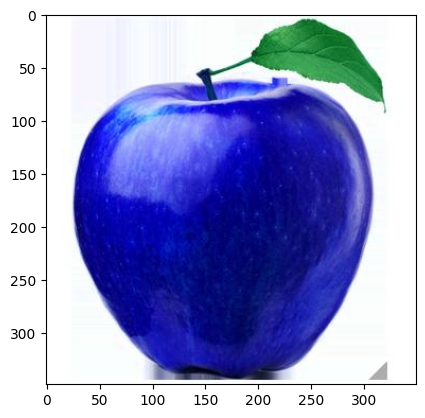

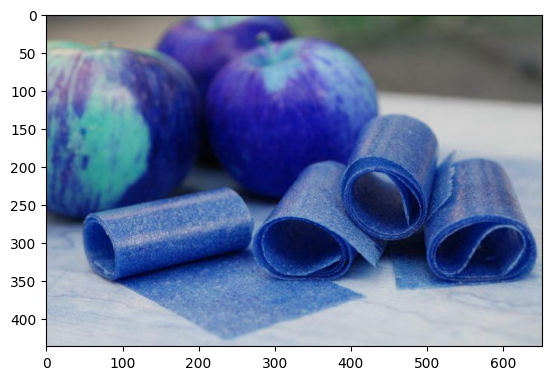

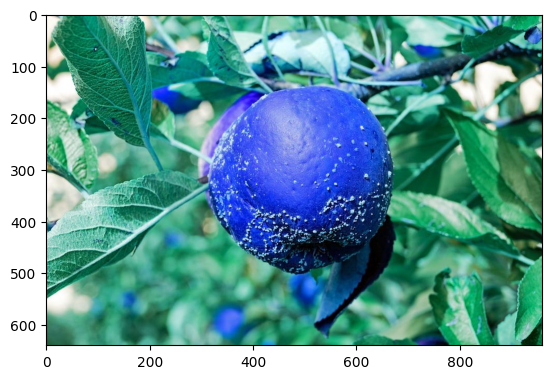

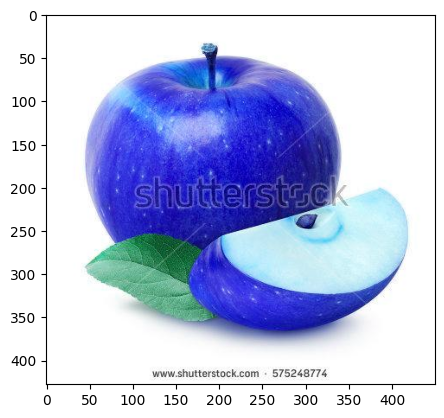

In [13]:
for idx, image in enumerate(os.listdir(image_dir)):
    img = cv2.imread(os.path.join(image_dir, image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

**<font size="5" color="lightgreen">Создадим список с именами файлов</font>**

In [14]:
img_file_path = []
for img in os.listdir(image_dir):
    image  = cv2.imread(os.path.join(image_dir, img), 0)
    img_file_path.append(f'{img}')

In [15]:
img_file_path

['apple_1.jpeg',
 'apple_11.jpeg',
 'apple_14.jpeg',
 'apple_12.jpeg',
 'apple_10.jpeg',
 'apple_23.jpeg',
 'apple_13.jpeg',
 'apple_19.jpeg',
 'apple_25.jpeg',
 'apple_15.jpeg',
 'apple_21.jpeg',
 'apple_18.jpeg',
 'apple_26.jpeg',
 'apple_27.jpeg',
 'apple_2.jpeg',
 'apple_16.jpeg',
 'apple_17.jpeg',
 'apple_28.jpeg',
 'apple_22.jpeg',
 'apple_24.jpeg',
 'apple_20.jpeg',
 'apple_31.jpeg',
 'apple_33.jpeg',
 'apple_41.jpeg',
 'apple_39.jpeg',
 'apple_36.jpeg',
 'apple_29.jpeg',
 'apple_3.jpeg',
 'apple_32.jpeg',
 'apple_37.jpeg',
 'apple_4.jpeg',
 'apple_42.jpeg',
 'apple_35.jpeg',
 'apple_38.jpeg',
 'apple_30.jpeg',
 'apple_43.jpeg',
 'apple_40.jpeg',
 'apple_47.jpeg',
 'apple_50.jpeg',
 'apple_53.jpeg',
 'apple_5.jpeg',
 'apple_46.jpeg',
 'apple_48.jpeg',
 'apple_55.jpeg',
 'apple_56.jpeg',
 'apple_51.jpeg',
 'apple_45.jpeg',
 'apple_52.jpeg',
 'apple_44.jpeg',
 'apple_54.jpeg',
 'apple_57.jpeg',
 'apple_49.jpeg',
 'apple_69.jpeg',
 'apple_62.jpeg',
 'apple_63.jpeg',
 'apple_67.jpeg

## 2. Засплитим данные

Разделим выборку на обучающую и тренировочную

In [16]:
train, val = train_test_split(img_file_path, test_size=0.2, random_state=101)

**<font size="5" color="lightgreen">Первую модель, которую я взял для дообучения на своем наборе данных была YOLO_V5</font>**

Для начала скачаем её

In [17]:
!pip install protobuf==3.19.3
!pip install soundfile==0.12.1
!pip install google-api-python-client==1.7.8
!pip install PyYAML==5.4
!pip install dask==2023.3.2
!pip install cupy-cuda11x==9.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.4.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.19.3 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.19.3 which is incompatible.
google-cloud-aiplatform 1.39.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.19.3 which is incompatible.
google-clo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.6.3 requires google-api-python-client>=1.12.5, but you have google-api-python-client 1.7.8 which is incompatible.
earthengine-api 0.1.386 requires google-api-python-client>=1.12.1, but you have google-api-python-client 1.7.8 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.8/174.8 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2023.8.1
    Uninstalling dask-2023.8.1:
      Successfully uninstalled dask-2023.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [18]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16408, done.
remote: Total 16408 (delta 0), reused 0 (delta 0), pack-reused 16408
Receiving objects: 100% (16408/16408), 14.96 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (11263/11263), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


**<font size="4" color="lightgreen">Создадим даталоадер для обучения</font>**

In [19]:
os.makedirs('yolov5/data/train')
os.makedirs('yolov5/data/val')
os.makedirs('yolov5/data/train/images')
os.makedirs('yolov5/data/train/labels')
os.makedirs('yolov5/data/val/images')
os.makedirs('yolov5/data/val/labels')

In [20]:
def copy_image_file(image_items, folder_name):
    image_dir = '/content/drive/MyDrive/detection/working/train/image'
    for image in image_items:
        img = Image.open(f'{image_dir}/{image}')
        img1 = img.resize((640, 480))
        _ = img1.save(f'yolov5/data/{folder_name}/images/{image}')

In [21]:
copy_image_file(train, 'train')
copy_image_file(val, 'val')

In [22]:
df1['xmin'] = (640/df1['width']) * df1['xmin']
df1['ymin'] = (480/df1['height']) * df1['ymin']
df1['xmax'] = (640/df1['width']) * df1['xmax']
df1['ymax'] = (480/df1['height']) * df1['ymax']
df1

name   label  width  height        xmin        ymin        xmax  \
0     apple_12   apple    450     428   61.155556   23.551402  497.777778   
1     apple_13   apple    800     800  332.000000  156.600000  576.000000   
2     apple_13   apple    800     800   84.000000  255.600000  314.400000   
3     apple_13   apple    800     800  155.200000  174.000000  381.600000   
4      apple_1   apple      0       0         inf         inf         inf   
..         ...     ...    ...     ...         ...         ...         ...   
460   orange_8  orange    600     393   44.800000  105.038168  300.800000   
461   orange_8  orange    600     393  310.400000   98.931298  581.333333   
462  orange_76  orange   1620    1080  195.160494    0.444444  573.629630   
463  orange_76  orange   1620    1080  324.740741  285.777778  640.000000   
464   orange_9  orange    500     427   44.800000  107.915691  343.040000   

           ymax  class  
0    395.887850      1  
1    340.200000      1  
2    414.600000      1  
3    327.000000      1  
4           inf      1  
..          ...    ...  
460  403.053435      0  
461  425.038168      0  
462  329.333333      0  
463  473.777778      0  
464  354.098361      0  

[465 rows x 9 columns]

In [23]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(inplace=True)
df1

name   label  width  height        xmin        ymin        xmax  \
0     apple_12   apple    450     428   61.155556   23.551402  497.777778   
1     apple_13   apple    800     800  332.000000  156.600000  576.000000   
2     apple_13   apple    800     800   84.000000  255.600000  314.400000   
3     apple_13   apple    800     800  155.200000  174.000000  381.600000   
5     apple_11   apple    652     436  209.079755   36.330275  450.552147   
..         ...     ...    ...     ...         ...         ...         ...   
460   orange_8  orange    600     393   44.800000  105.038168  300.800000   
461   orange_8  orange    600     393  310.400000   98.931298  581.333333   
462  orange_76  orange   1620    1080  195.160494    0.444444  573.629630   
463  orange_76  orange   1620    1080  324.740741  285.777778  640.000000   
464   orange_9  orange    500     427   44.800000  107.915691  343.040000   

           ymax  class  
0    395.887850      1  
1    340.200000      1  
2    414.600000      1  
3    327.000000      1  
5    284.036697      1  
..          ...    ...  
460  403.053435      0  
461  425.038168      0  
462  329.333333      0  
463  473.777778      0  
464  354.098361      0  

[420 rows x 9 columns]

In [24]:
df1[['xmin', 'ymin', 'xmax', 'ymax']] = df1[['xmin', 'ymin', 'xmax', 'ymax']].astype('int')

In [25]:
WIDTH = 640
HEIGHT = 480

df1['x_center'] = (df1['xmin']+df1['xmax'])/(2*WIDTH)
df1['y_center'] = (df1['ymin']+df1['ymax'])/(2*HEIGHT)
df1['box_width'] = (df1['xmax']-df1['xmin'])/ WIDTH
df1['box_height'] = (df1['ymax']-df1['ymin'])/ HEIGHT

df1 = df1.astype(str)

In [26]:
def copy_label(label_items, folder_name):
    image_dir = '/content/drive/MyDrive/detection/working/train/labels'
    file_name = [x.split('.')[0] for x in img_file_path]
    for name in file_name:
        data = df1[df1.name == name]

        box_list = []
        for idx in range(len(data)):
            row = data.iloc[idx]
            box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

        text = "\n".join(box_list)
        with open(f'yolov5/data/{folder_name}/labels/{name}.txt', 'w') as file:
            file.write(text)

In [27]:
copy_label(train, 'train')
copy_label(val, 'val')

In [75]:
!ls yolov5/data/val/

images	labels	labels.cache


In [29]:
yaml_text = """train: yolov5/data/train/images
val: yolov5/data/val/images

nc: 3
names: ['orange', 'apple', 'banana']"""

with open("yolov5/data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat yolov5/data/data.yaml

train: yolov5/data/train/images
val: yolov5/data/val/images

nc: 3
names: ['orange', 'apple', 'banana']

**<font size="5" color="lightgreen">Дообучаем модель на своем наборе данных</font>**

In [30]:
!python train.py --img 640 --epochs 35 --batch 64 --data yolov5/data/data.yaml --cfg yolov5s.yaml --weights yolov5s.pt --name fruit_detection_yolov5

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=yolov5/data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=35, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=fruit_detection_yolov5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-283-g875d9278 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr

## 3. Выведем результаты обучения

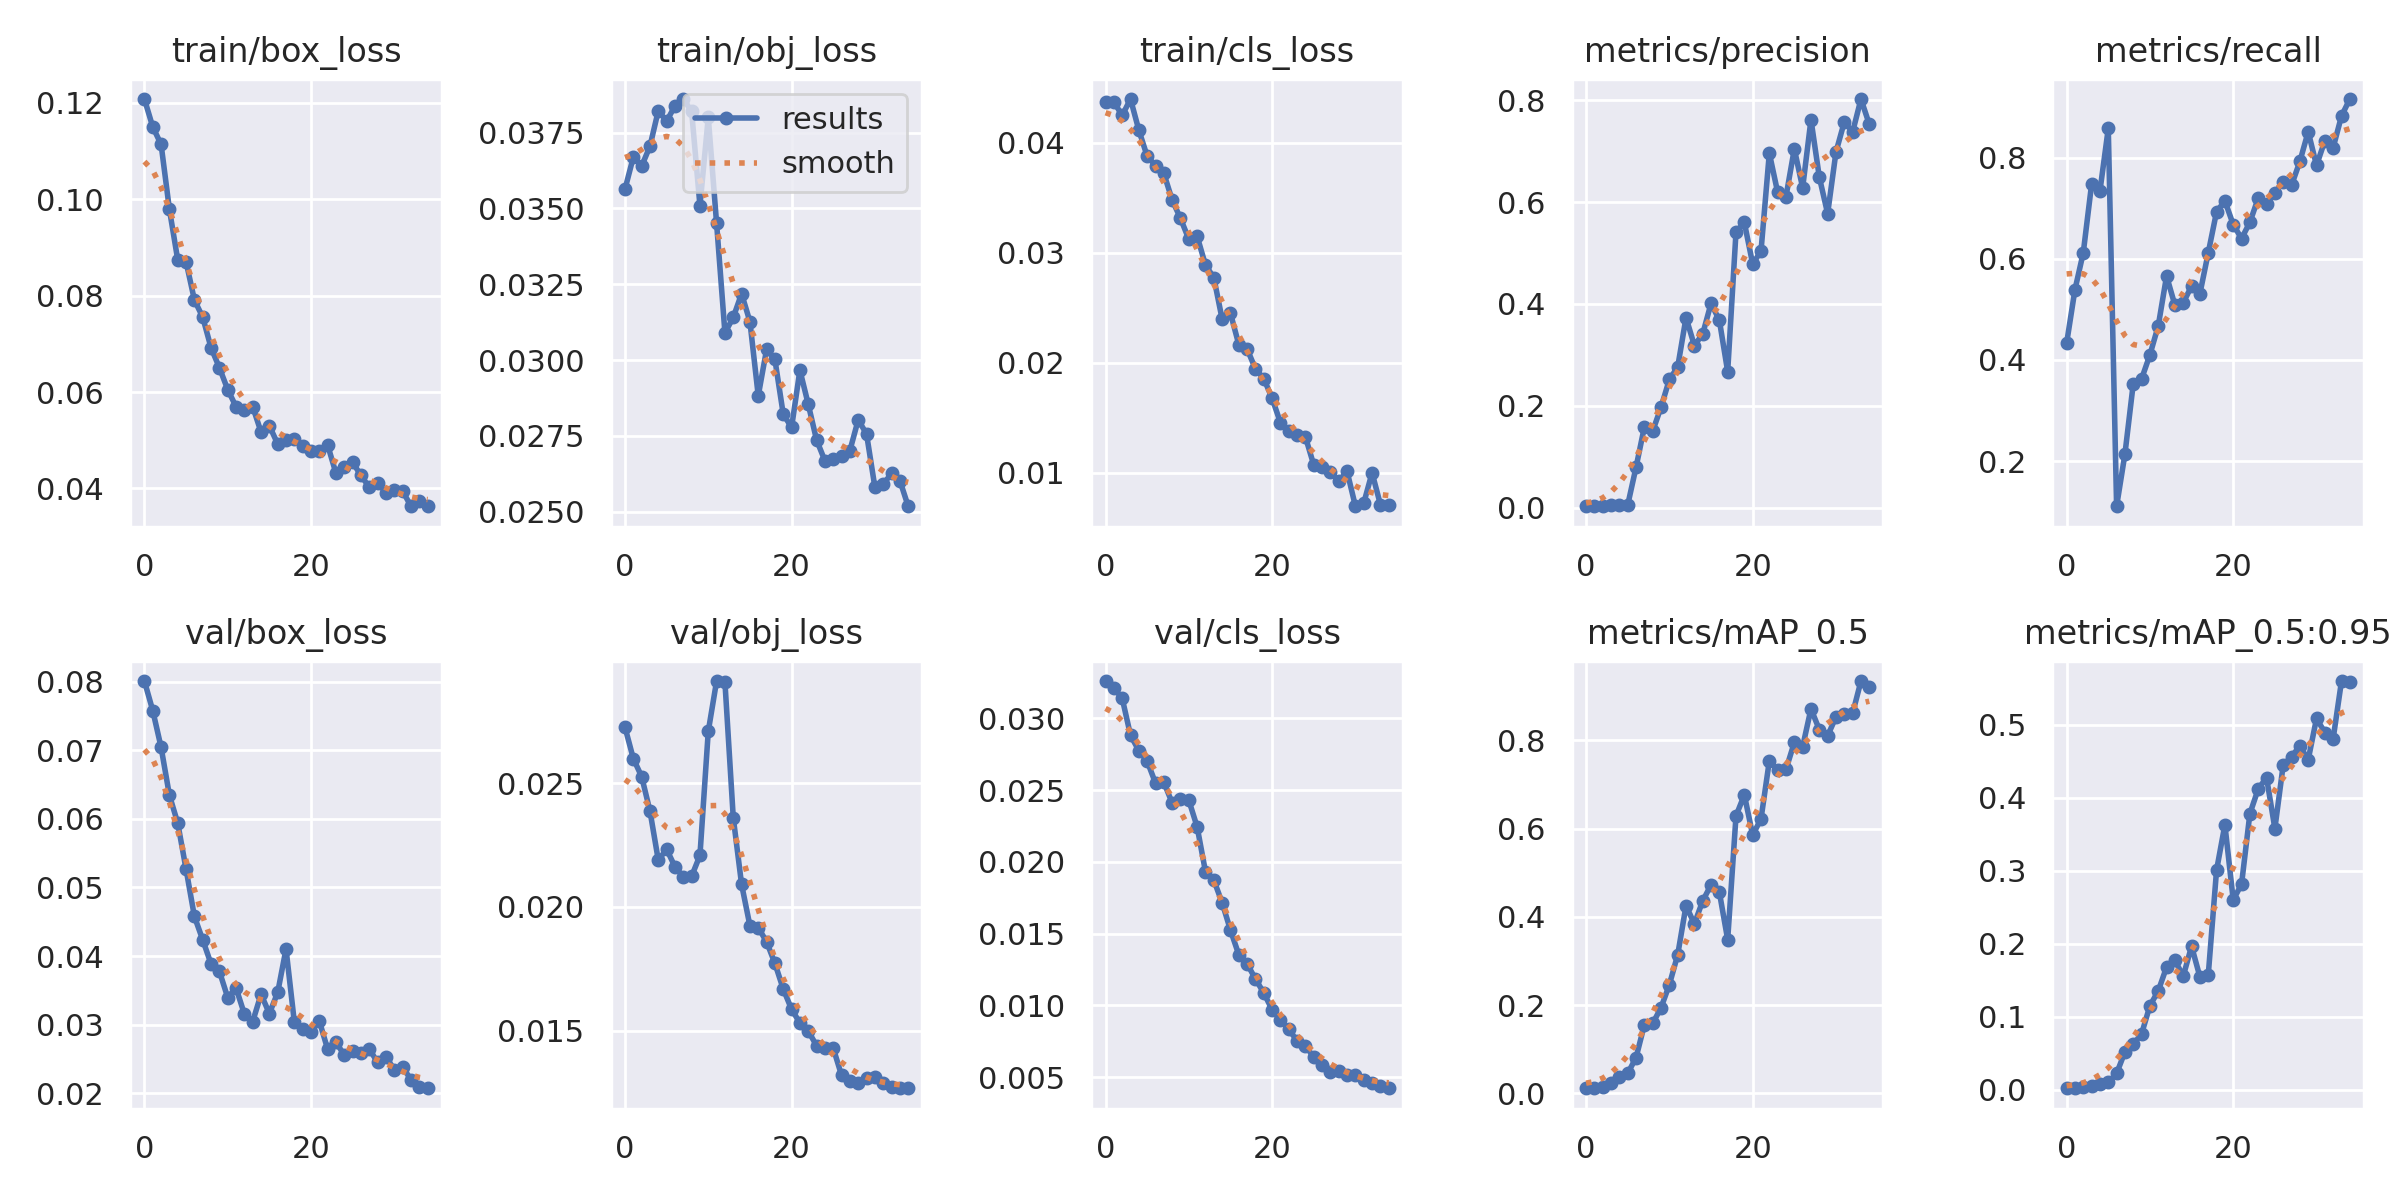

In [31]:
from IPython.display import Image as Display

Display(filename='runs/train/fruit_detection_yolov5/results.png', width=1080)

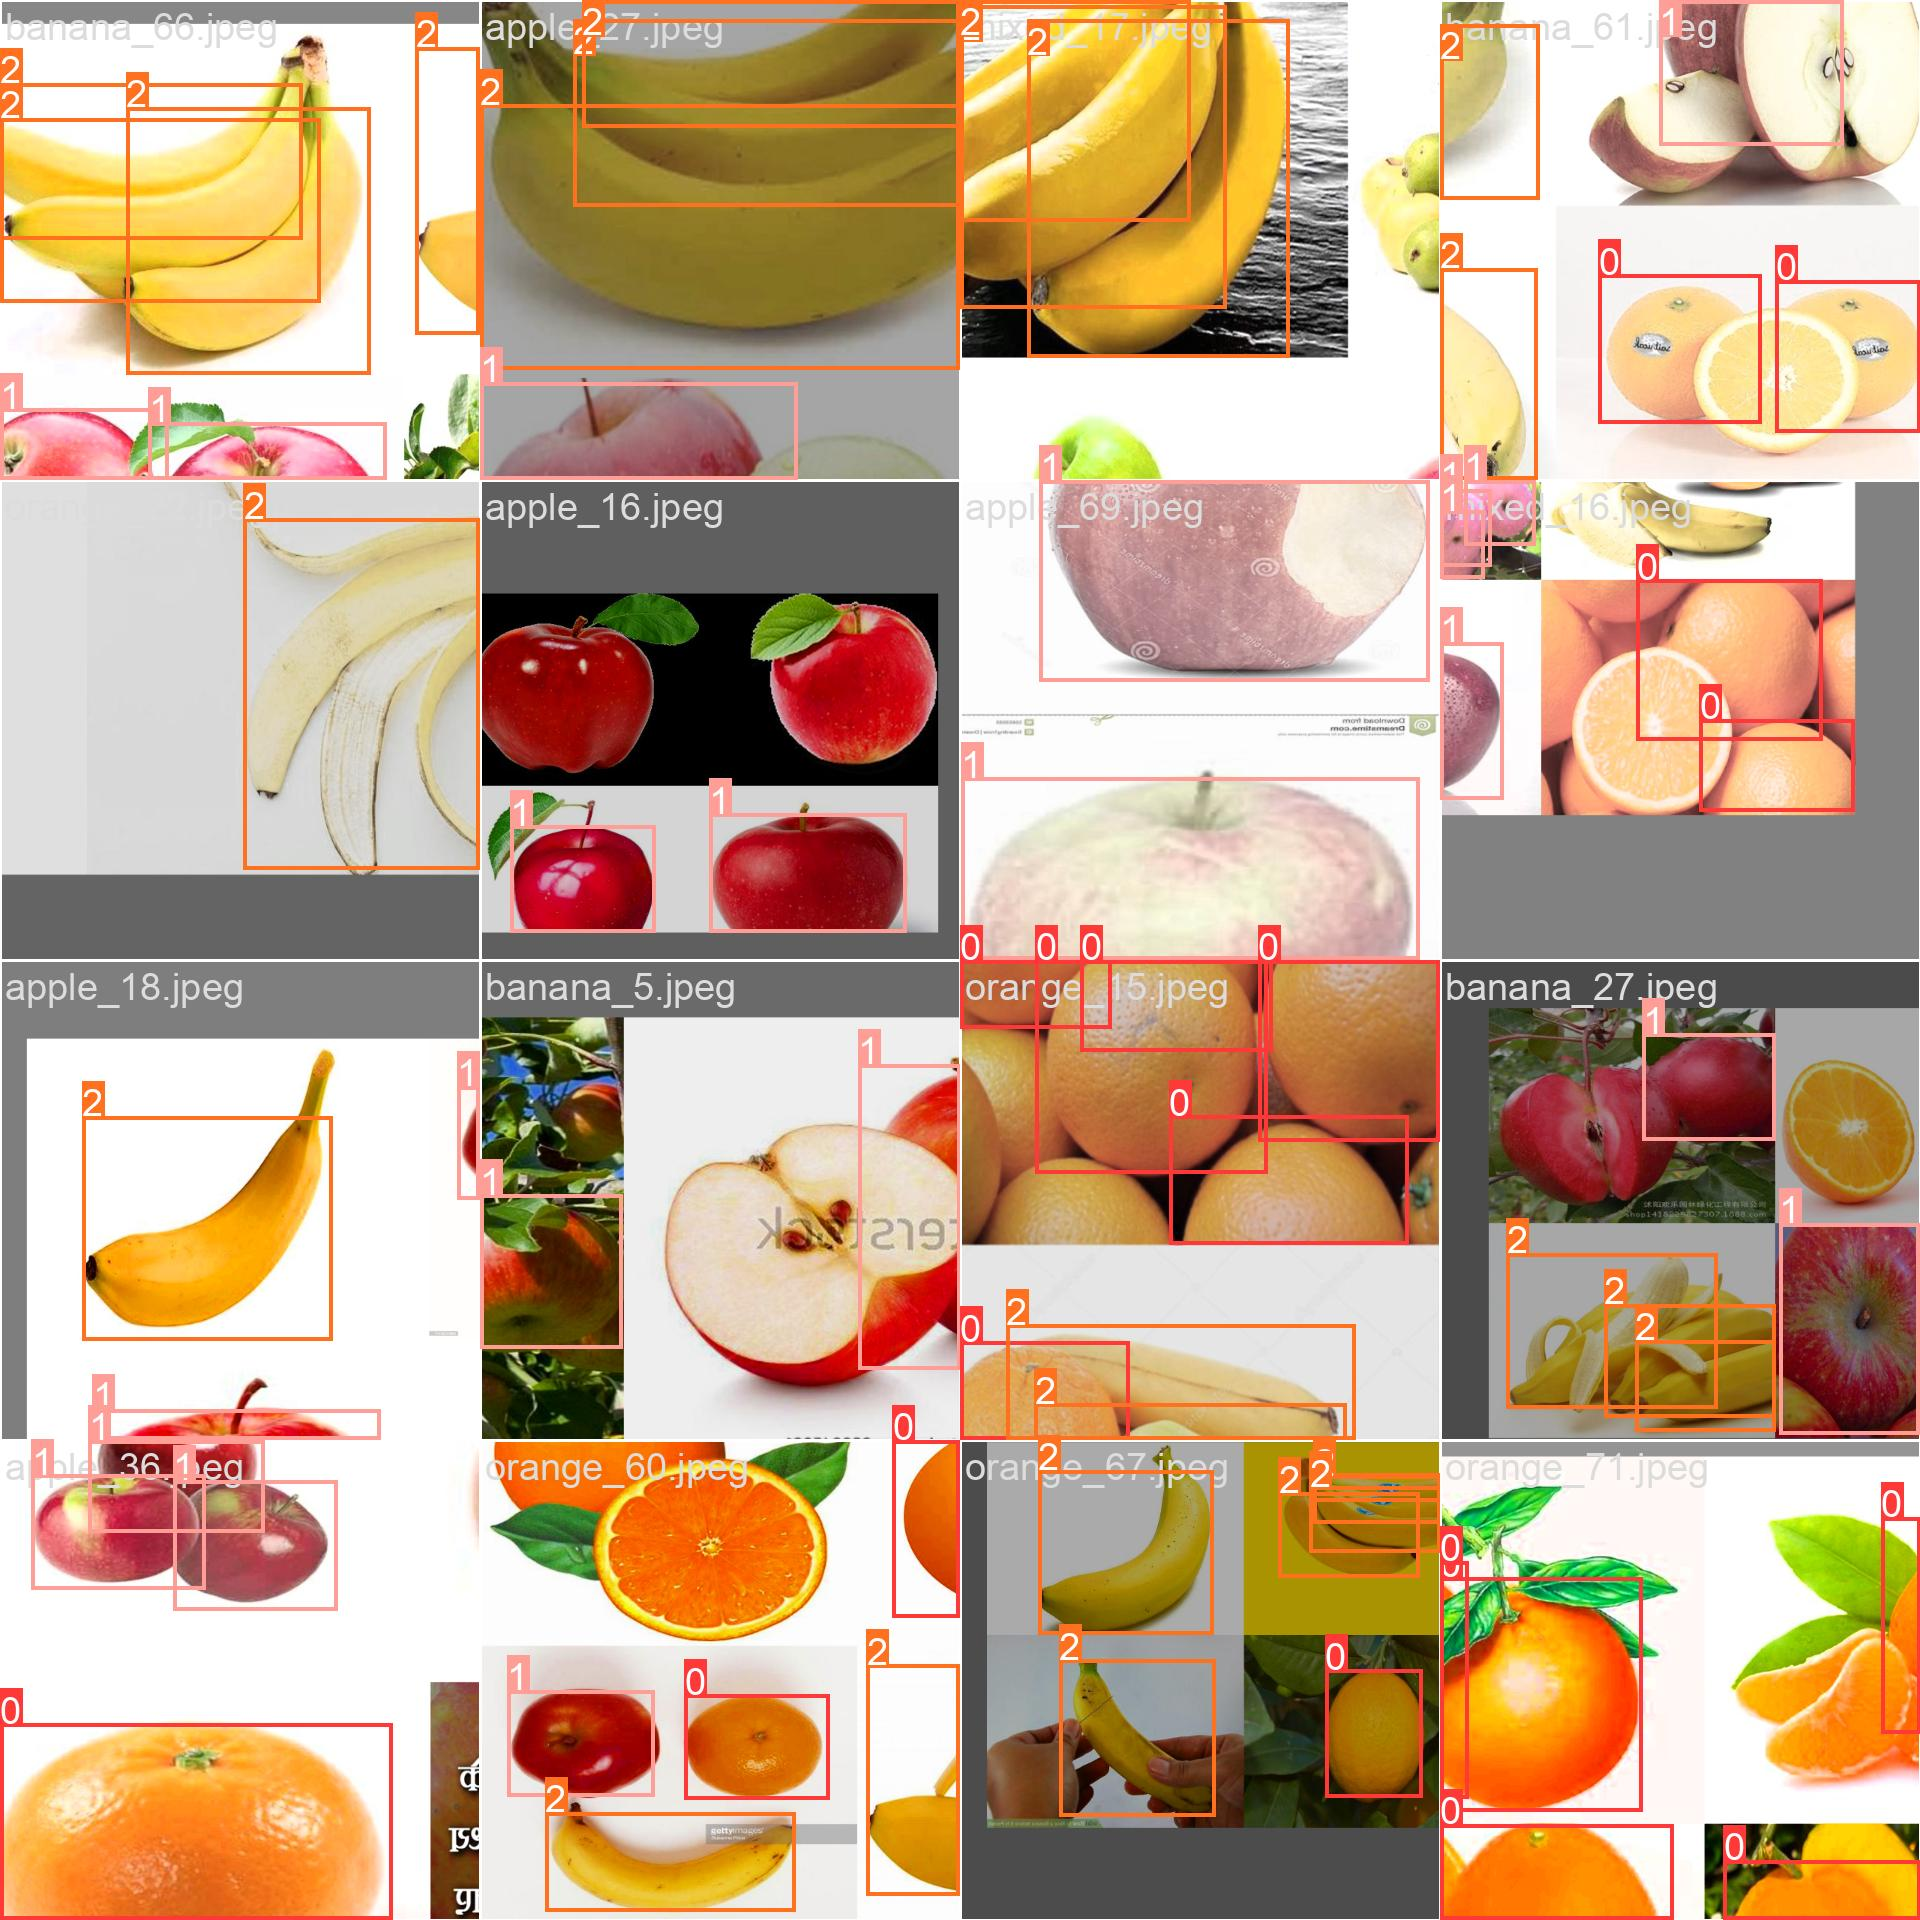

In [32]:
Display(filename='runs/train/fruit_detection_yolov5/train_batch0.jpg', width=1000)

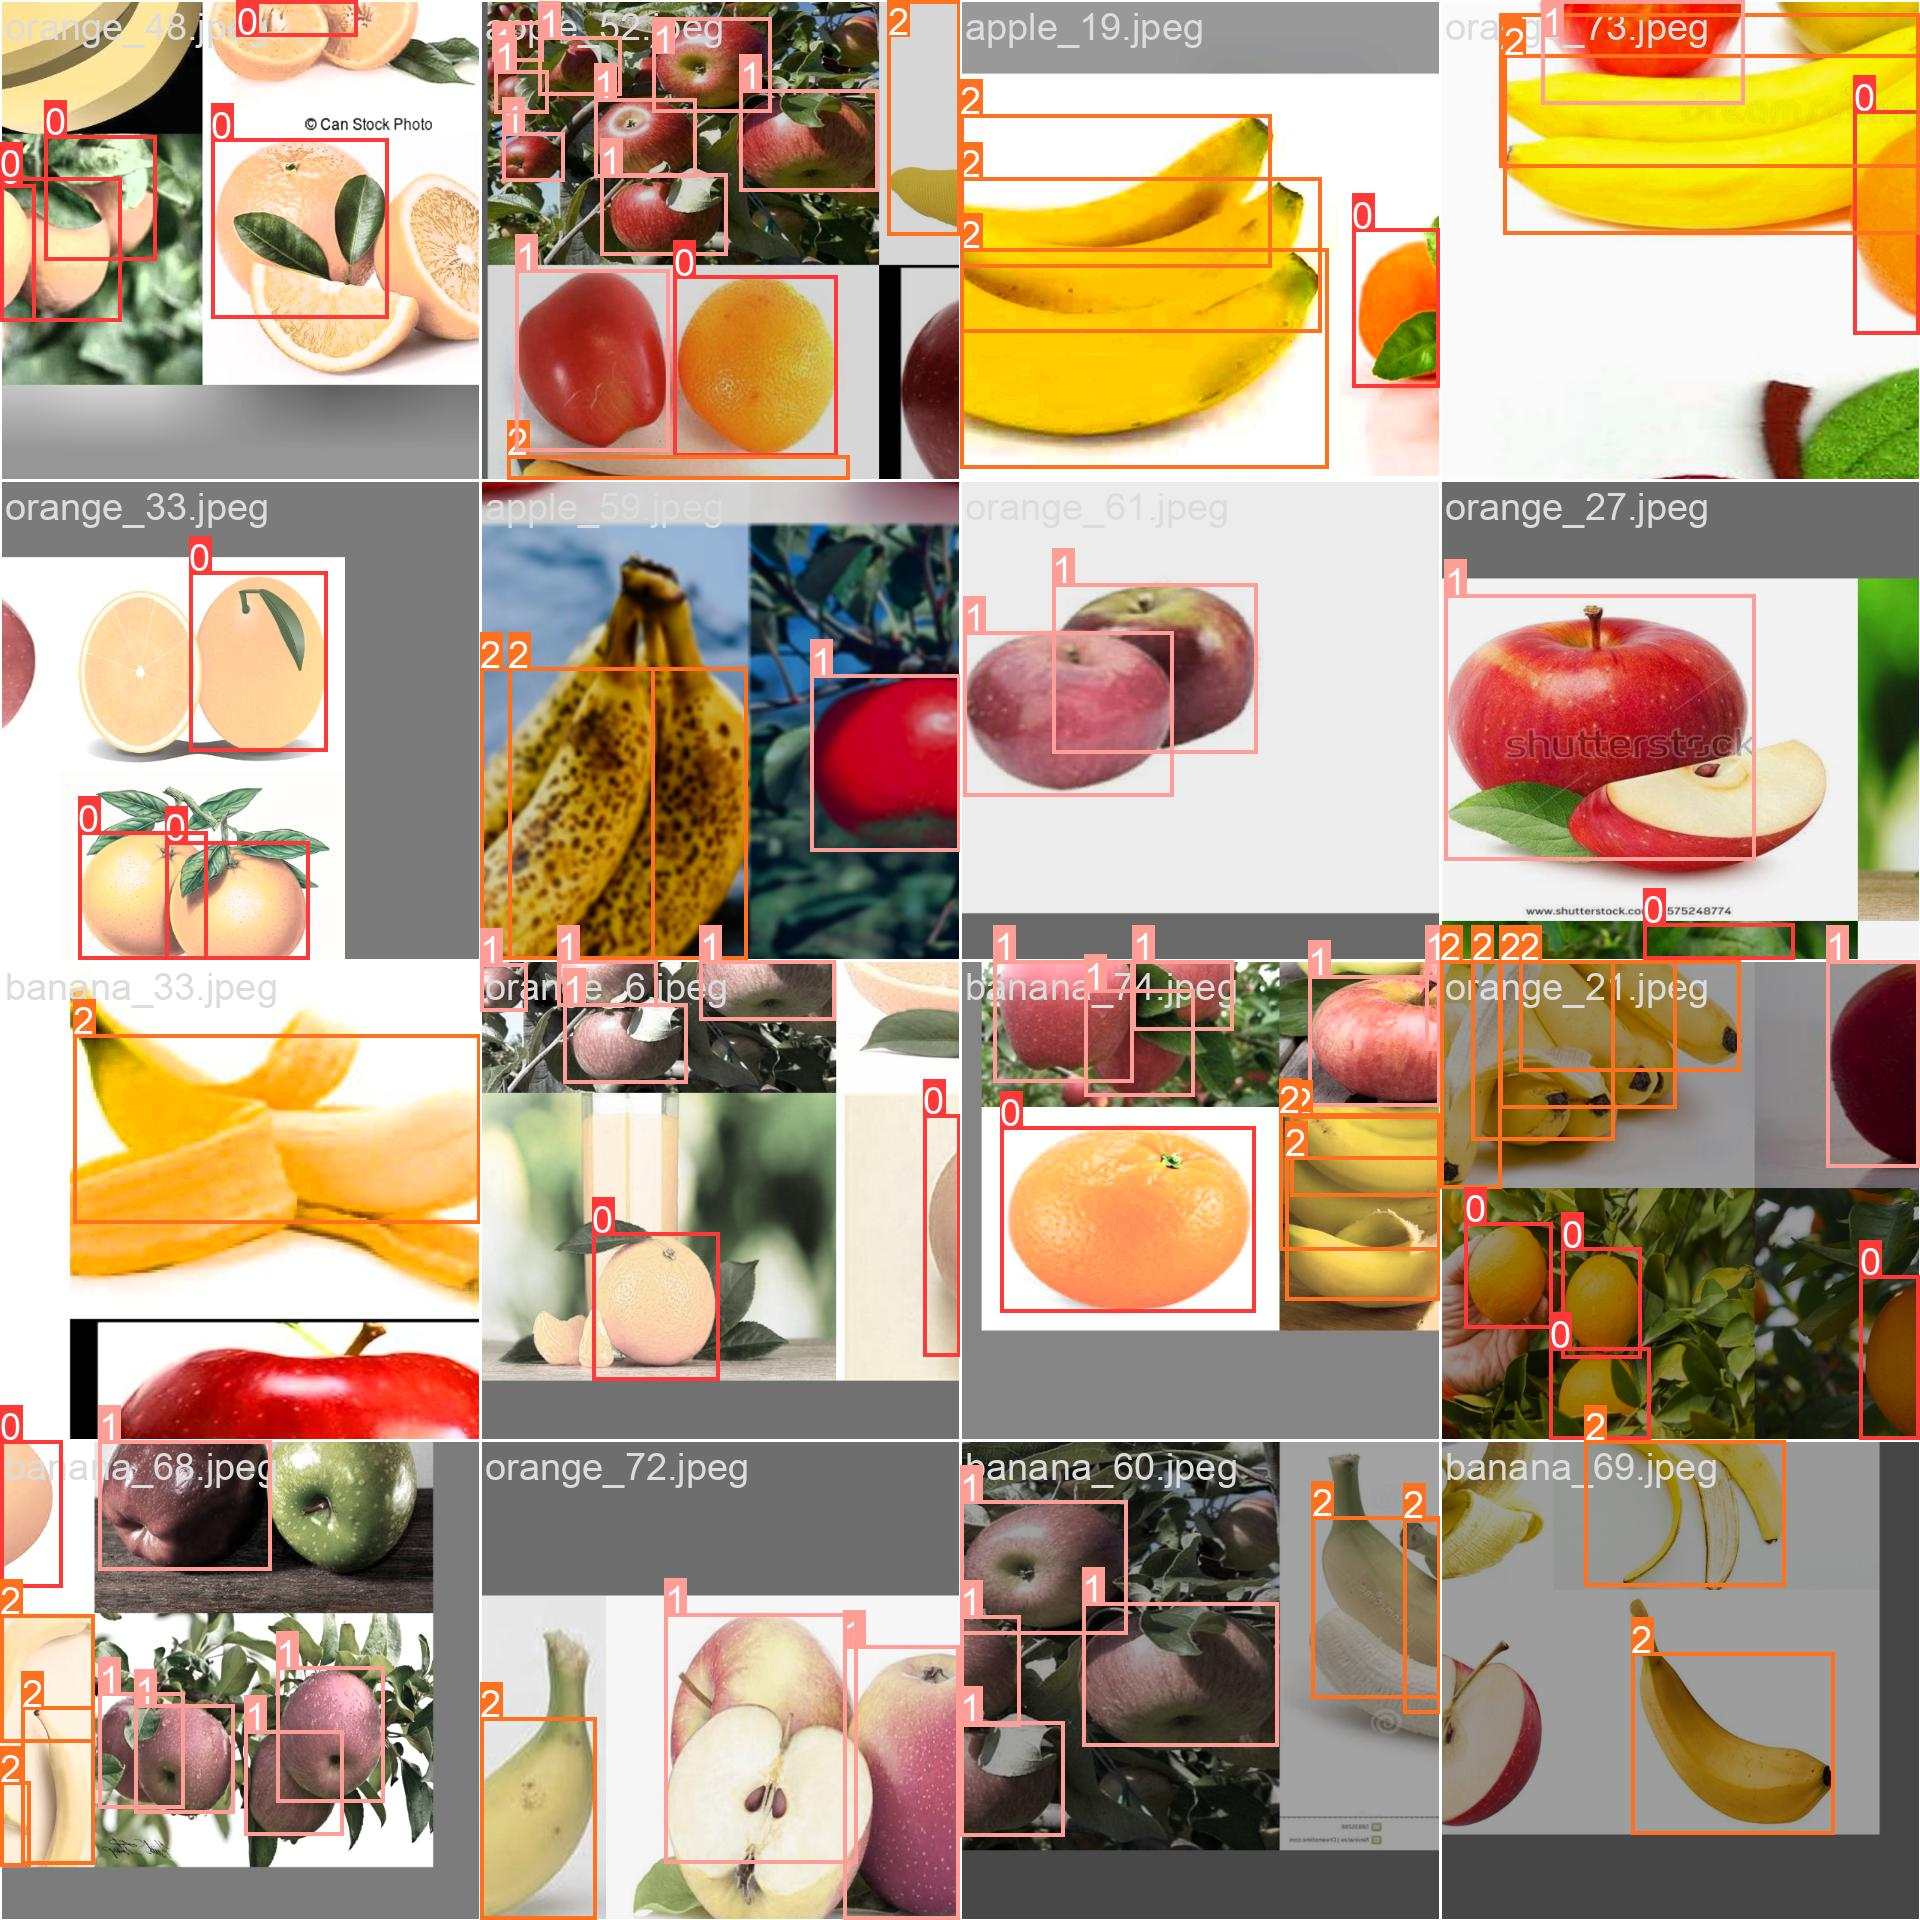

In [33]:
Display(filename='runs/train/fruit_detection_yolov5/train_batch1.jpg', width=1000)

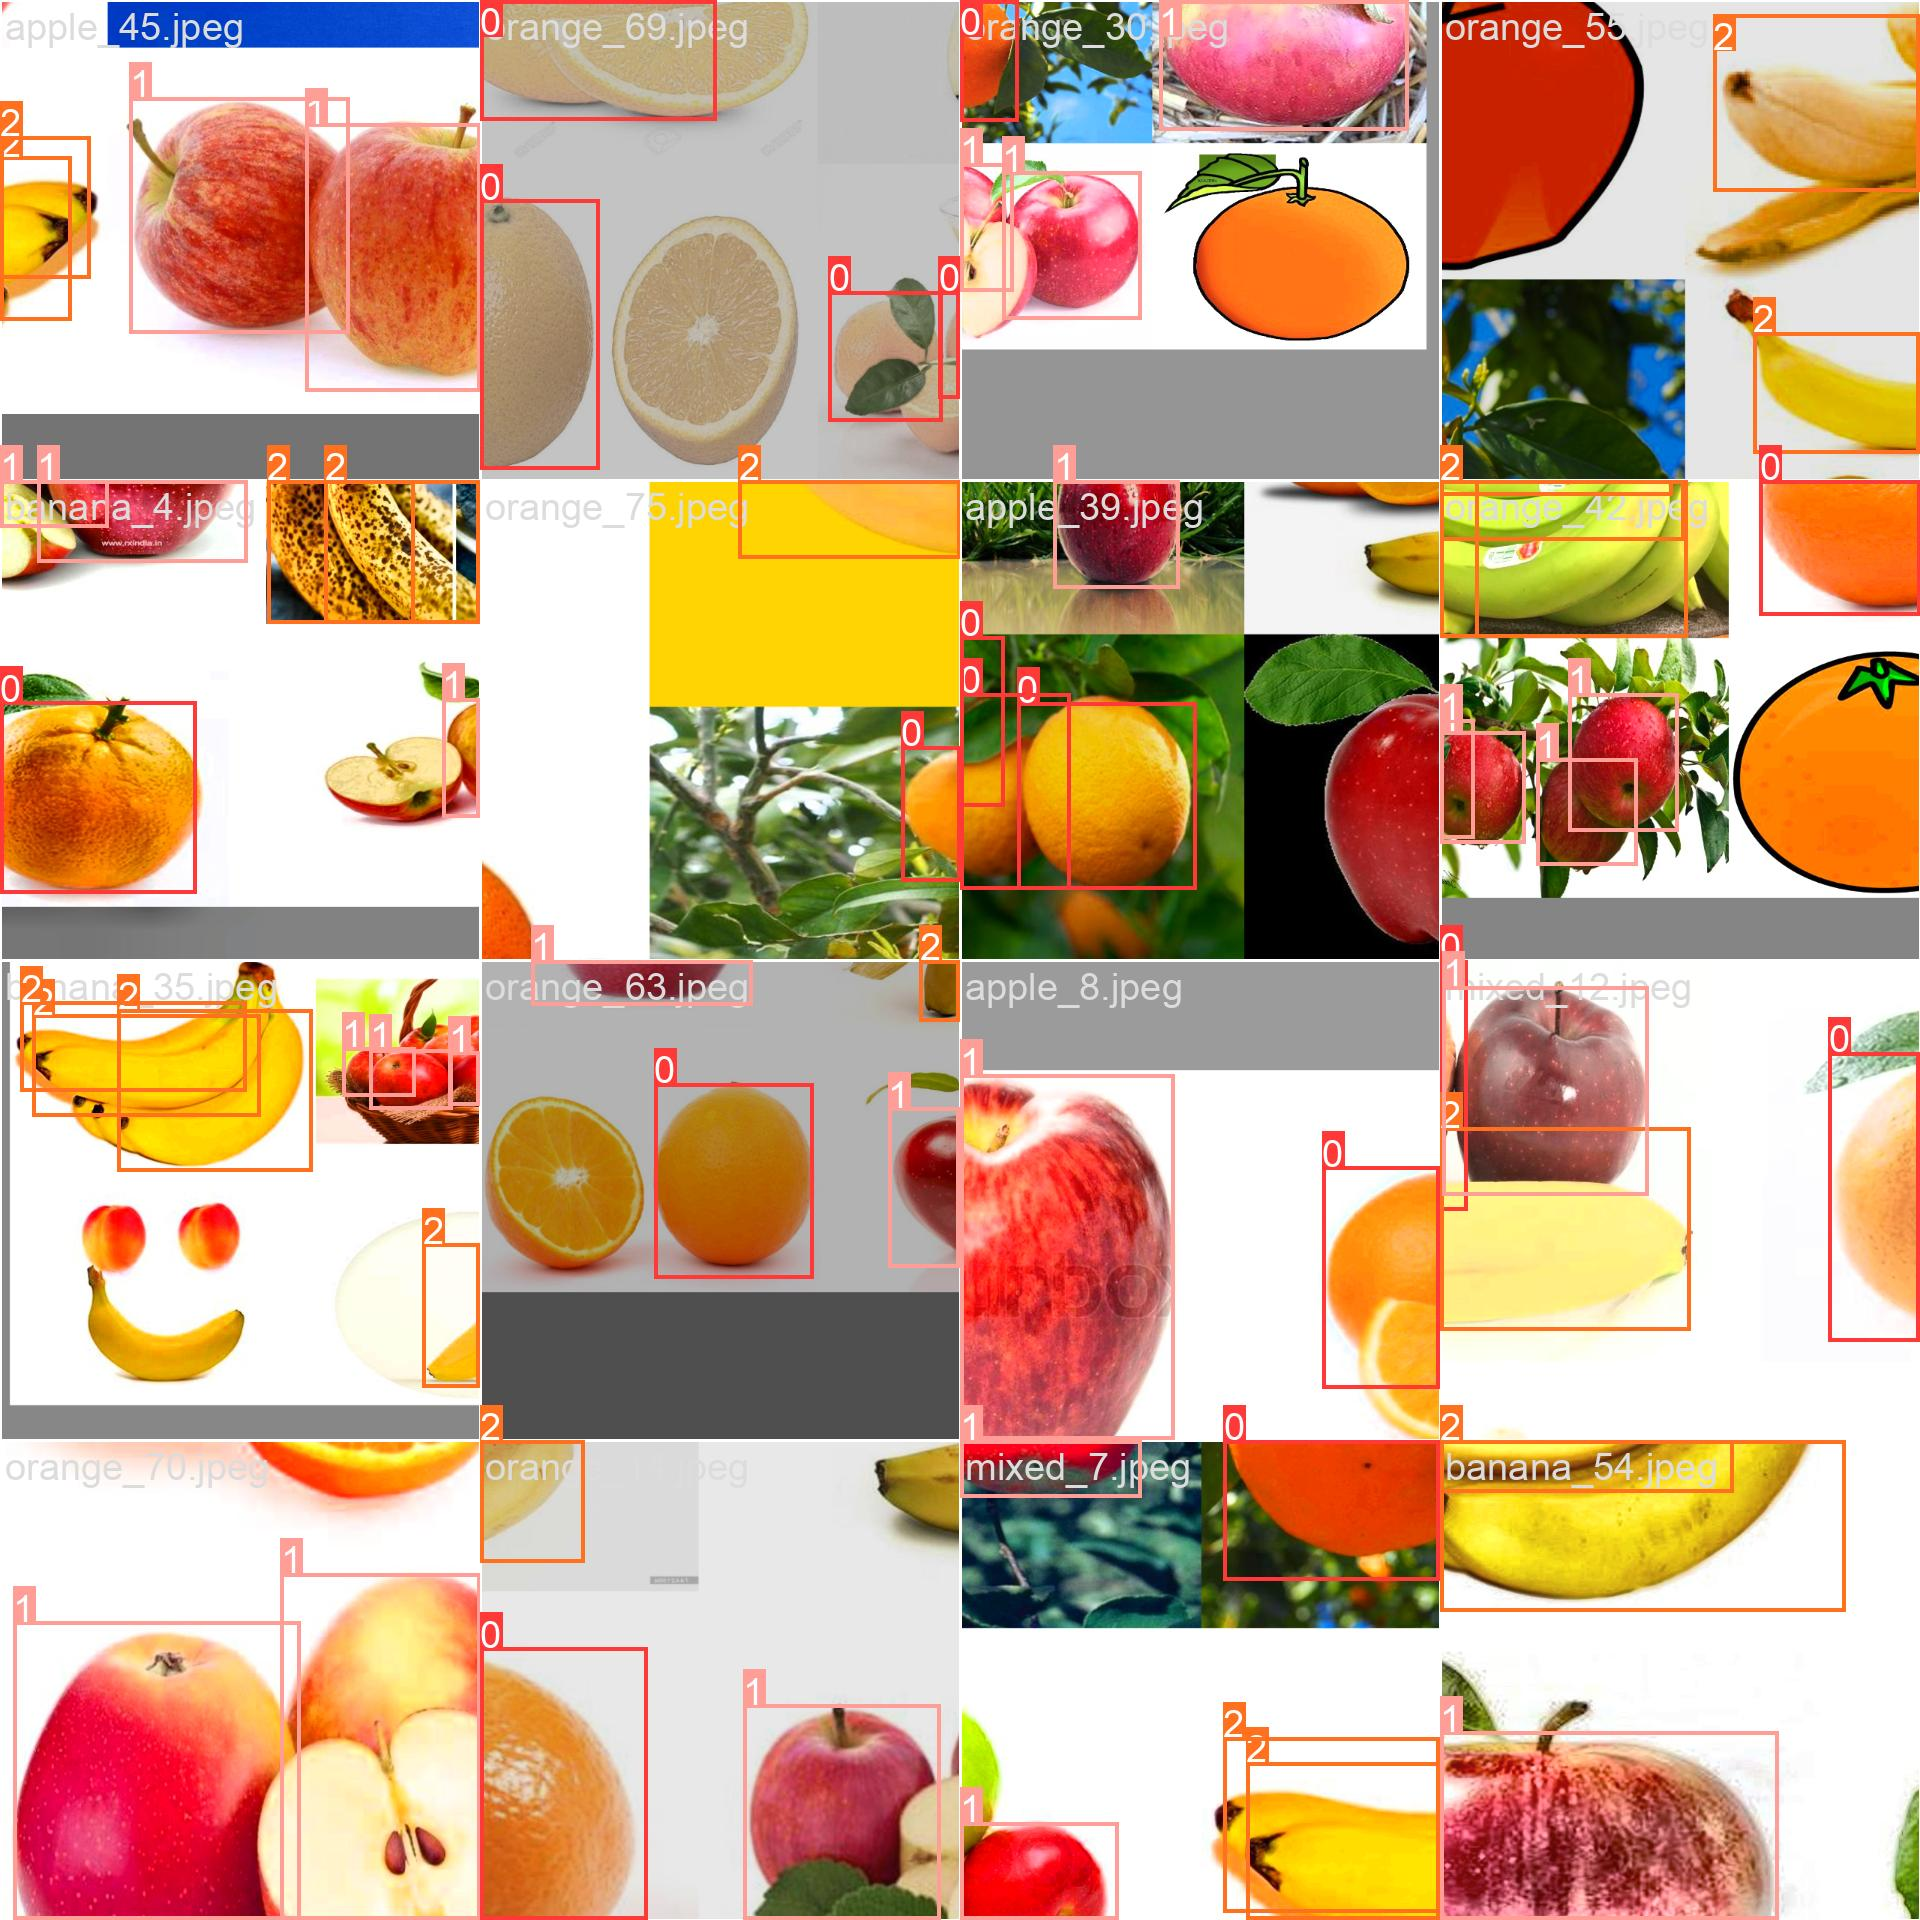

In [34]:
Display(filename='runs/train/fruit_detection_yolov5/train_batch2.jpg', width=1000)

In [35]:
!ls /content/drive/MyDrive/detection/test

apple_77.jpg  apple_87.jpg   banana_78.jpg  banana_88.jpg  mixed_24.jpg   orange_85.jpg
apple_77.xml  apple_87.xml   banana_78.xml  banana_88.xml  mixed_24.xml   orange_85.xml
apple_78.jpg  apple_88.jpg   banana_79.jpg  banana_89.jpg  mixed_25.jpg   orange_86.jpg
apple_78.xml  apple_88.xml   banana_79.xml  banana_89.xml  mixed_25.xml   orange_86.xml
apple_79.jpg  apple_89.jpg   banana_80.jpg  banana_90.jpg  orange_77.jpg  orange_87.jpg
apple_79.xml  apple_89.xml   banana_80.xml  banana_90.xml  orange_77.xml  orange_87.xml
apple_80.jpg  apple_90.jpg   banana_81.jpg  banana_91.jpg  orange_78.jpg  orange_89.jpg
apple_80.xml  apple_90.xml   banana_81.xml  banana_91.xml  orange_78.xml  orange_89.xml
apple_81.jpg  apple_91.jpg   banana_82.jpg  banana_92.jpg  orange_79.jpg  orange_90.jpg
apple_81.xml  apple_91.xml   banana_82.xml  banana_92.xml  orange_79.xml  orange_90.xml
apple_82.jpg  apple_92.jpg   banana_83.jpg  banana_93.jpg  orange_80.jpg  orange_91.jpg
apple_82.xml  apple_92.xml   ban

## 4. Протестируем модель на тестовых данных

In [36]:
!python detect.py --weights runs/train/fruit_detection_yolov5/weights/best.pt --img-size 640 --conf 0.4 --source /content/drive/MyDrive/detection/test

detect: weights=['runs/train/fruit_detection_yolov5/weights/best.pt'], source=/content/drive/MyDrive/detection/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-283-g875d9278 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/60 /content/drive/MyDrive/detection/test/apple_77.jpg: 512x640 5 apples, 81.3ms
image 2/60 /content/drive/MyDrive/detection/test/apple_78.jpg: 640x640 (no detections), 19.5ms
libpng warning: iCCP: known incorrect sRGB profile
image 3/60 /con

In [37]:
!ls runs/detect/exp

apple_77.jpg  apple_87.jpg   banana_78.jpg  banana_88.jpg  mixed_24.jpg   orange_85.jpg
apple_78.jpg  apple_88.jpg   banana_79.jpg  banana_89.jpg  mixed_25.jpg   orange_86.jpg
apple_79.jpg  apple_89.jpg   banana_80.jpg  banana_90.jpg  orange_77.jpg  orange_87.jpg
apple_80.jpg  apple_90.jpg   banana_81.jpg  banana_91.jpg  orange_78.jpg  orange_89.jpg
apple_81.jpg  apple_91.jpg   banana_82.jpg  banana_92.jpg  orange_79.jpg  orange_90.jpg
apple_82.jpg  apple_92.jpg   banana_83.jpg  banana_93.jpg  orange_80.jpg  orange_91.jpg
apple_83.jpg  apple_93.jpg   banana_84.jpg  banana_94.jpg  orange_81.jpg  orange_92.jpg
apple_84.jpg  apple_94.jpg   banana_85.jpg  mixed_21.jpg   orange_82.jpg  orange_93.jpg
apple_85.jpg  apple_95.jpg   banana_86.jpg  mixed_22.jpg   orange_83.jpg  orange_94.jpg
apple_86.jpg  banana_77.jpg  banana_87.jpg  mixed_23.jpg   orange_84.jpg  orange_95.jpg


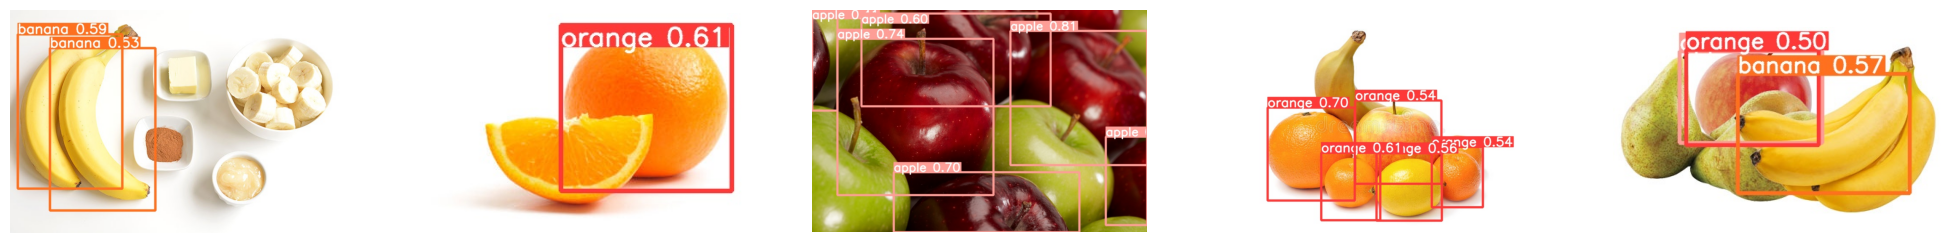

In [38]:
import matplotlib.image as mpimg

image_paths = [
    "runs/detect/exp/banana_91.jpg",
    "runs/detect/exp/orange_92.jpg",
    "runs/detect/exp/apple_84.jpg",
    "runs/detect/exp/mixed_21.jpg",
    "runs/detect/exp/mixed_24.jpg"
]

def show_images(image_paths):
    fig = plt.figure(figsize=(25, 6))
    for i, image_path in enumerate(image_paths, 1):
        ax = fig.add_subplot(1, 5, i)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis("off")
    plt.show()

show_images(image_paths)

**<font size="4" color="lightgreen">Так как в задании сказано взять две модели и сравнить их то возьмем в качестве второй модели YOLO_V8 и сравним результаты</font>**

In [39]:
!pip install ultralytics

In [40]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 53.0MB/s]


**<font size="4" color="lightgreen">У меня были проблемы почему-то с собучением на старам даталоадере, поэтому я сделал новый</font>**

In [ ]:
os.makedirs('yolov8/data/train')
os.makedirs('yolov8/data/val')
os.makedirs('yolov8/data/train/images')
os.makedirs('yolov8/data/train/labels')
os.makedirs('yolov8/data/val/images')
os.makedirs('yolov8/data/val/labels')

In [88]:
def copy_image_file(image_items, folder_name):
    image_dir = '/content/drive/MyDrive/detection/working/train/image'
    for image in image_items:
        img = Image.open(f'{image_dir}/{image}')
        img1 = img.resize((640, 480))
        _ = img1.save(f'yolov8/data/{folder_name}/images/{image}')

In [89]:
copy_image_file(train, 'train')
copy_image_file(val, 'val')

In [90]:
df2 = pd.DataFrame(df)
df2.head()

name  label  width  height  xmin  ymin  xmax  ymax
0  apple_12  apple    450     428    43    21   350   353
1  apple_13  apple    800     800   415   261   720   567
2  apple_13  apple    800     800   105   426   393   691
3  apple_13  apple    800     800   194   290   477   545
4   apple_1  apple      0       0     8    15   331   349

In [91]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    465 non-null    object
 1   label   465 non-null    object
 2   width   465 non-null    int64 
 3   height  465 non-null    int64 
 4   xmin    465 non-null    int64 
 5   ymin    465 non-null    int64 
 6   xmax    465 non-null    int64 
 7   ymax    465 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 29.2+ KB


In [92]:
df2['label'].unique()

array(['apple', 'banana', 'orange'], dtype=object)

In [93]:
label_map = { 'orange': 0,
            'apple': 1,
            'banana': 2}

df2['class'] = df2['label'].map(label_map)

In [94]:
df2['xmin'] = (640/df2['width']) * df2['xmin']
df2['ymin'] = (480/df2['height']) * df2['ymin']
df2['xmax'] = (640/df2['width']) * df2['xmax']
df2['ymax'] = (480/df2['height']) * df2['ymax']
df2

name   label  width  height        xmin        ymin        xmax  \
0     apple_12   apple    450     428   61.155556   23.551402  497.777778   
1     apple_13   apple    800     800  332.000000  156.600000  576.000000   
2     apple_13   apple    800     800   84.000000  255.600000  314.400000   
3     apple_13   apple    800     800  155.200000  174.000000  381.600000   
4      apple_1   apple      0       0         inf         inf         inf   
..         ...     ...    ...     ...         ...         ...         ...   
460   orange_8  orange    600     393   44.800000  105.038168  300.800000   
461   orange_8  orange    600     393  310.400000   98.931298  581.333333   
462  orange_76  orange   1620    1080  195.160494    0.444444  573.629630   
463  orange_76  orange   1620    1080  324.740741  285.777778  640.000000   
464   orange_9  orange    500     427   44.800000  107.915691  343.040000   

           ymax  class  
0    395.887850      1  
1    340.200000      1  
2    414.600000      1  
3    327.000000      1  
4           inf      1  
..          ...    ...  
460  403.053435      0  
461  425.038168      0  
462  329.333333      0  
463  473.777778      0  
464  354.098361      0  

[465 rows x 9 columns]

In [95]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.dropna(inplace=True)
df2

name   label  width  height        xmin        ymin        xmax  \
0     apple_12   apple    450     428   61.155556   23.551402  497.777778   
1     apple_13   apple    800     800  332.000000  156.600000  576.000000   
2     apple_13   apple    800     800   84.000000  255.600000  314.400000   
3     apple_13   apple    800     800  155.200000  174.000000  381.600000   
5     apple_11   apple    652     436  209.079755   36.330275  450.552147   
..         ...     ...    ...     ...         ...         ...         ...   
460   orange_8  orange    600     393   44.800000  105.038168  300.800000   
461   orange_8  orange    600     393  310.400000   98.931298  581.333333   
462  orange_76  orange   1620    1080  195.160494    0.444444  573.629630   
463  orange_76  orange   1620    1080  324.740741  285.777778  640.000000   
464   orange_9  orange    500     427   44.800000  107.915691  343.040000   

           ymax  class  
0    395.887850      1  
1    340.200000      1  
2    414.600000      1  
3    327.000000      1  
5    284.036697      1  
..          ...    ...  
460  403.053435      0  
461  425.038168      0  
462  329.333333      0  
463  473.777778      0  
464  354.098361      0  

[420 rows x 9 columns]

In [96]:
df2[['xmin', 'ymin', 'xmax', 'ymax']] = df2[['xmin', 'ymin', 'xmax', 'ymax']].astype('int')

In [97]:
WIDTH = 640
HEIGHT = 480

df2['x_center'] = (df2['xmin']+df2['xmax'])/(2*WIDTH)
df2['y_center'] = (df2['ymin']+df2['ymax'])/(2*HEIGHT)
df2['box_width'] = (df2['xmax']-df2['xmin'])/ WIDTH
df2['box_height'] = (df2['ymax']-df2['ymin'])/ HEIGHT

df2 = df2.astype(str)

In [98]:
def copy_label(label_items, folder_name):
    image_dir = '/content/drive/MyDrive/detection/working/train/labels'
    file_name = [x.split('.')[0] for x in img_file_path]
    for name in file_name:
        data = df2[df2.name == name]

        box_list = []
        for idx in range(len(data)):
            row = data.iloc[idx]
            box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

        text = "\n".join(box_list)
        with open(f'yolov8/data/{folder_name}/labels/{name}.txt', 'w') as file:
            file.write(text)

In [99]:
copy_label(train, 'train')
copy_label(val, 'val')

In [100]:
!ls yolov8/data/

data.yaml  train  val


In [168]:
yaml_text = """train: /content/yolov5/yolov8/data/train/images
val: /content/yolov5/yolov8/data/val/images

nc: 3
names: ['orange', 'apple', 'banana']"""

with open("/content/yolov5/yolov8/data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat /content/yolov5/yolov8/data/data.yaml

train: /content/yolov5/yolov8/data/train/images
val: /content/yolov5/yolov8/data/val/images

nc: 3
names: ['orange', 'apple', 'banana']

In [169]:
!ls data

data.yaml  train  val


In [ ]:
!ls /content/yolov5/yolov8/data/train/images

**<font size="4" color="lightgreen">Запускаем обучение на новом даталоадере</font>**

In [173]:
model = YOLO("yolov8n.pt")
model.train(data="/content/yolov5/yolov8/data/data.yaml", epochs=20)

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolov5/yolov8/data/data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /content/yolov5/yolov8/data/train/labels... 192 images, 27 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<00:00, 852.55it/s]

train: New cache created: /content/yolov5/yolov8/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolov5/yolov8/data/val/labels... 48 images, 6 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<00:00, 640.80it/s]

val: New cache created: /content/yolov5/yolov8/data/val/labels.cache


Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train13
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.3G      1.227      3.126      1.565         69        640: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         48         93    0.00631      0.977      0.305      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.26G      1.124      2.423      1.457         59        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         48         93      0.474      0.411       0.48      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.28G      1.125      2.062      1.471         68        640: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         48         93      0.858      0.187      0.548      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.28G      1.125        1.9      1.432         56        640: 100%|██████████| 12/12 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         48         93      0.566      0.604       0.63       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.26G      1.056      1.822      1.412         56        640: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         48         93      0.625      0.693      0.718      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.28G      1.039      1.669      1.365         73        640: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         48         93      0.672      0.697      0.684       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.124      1.601      1.413         63        640: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         48         93      0.544      0.739      0.696      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.26G      1.078      1.622      1.379         66        640: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         48         93      0.582       0.65      0.626      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.28G      1.083      1.494      1.352         74        640: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         48         93      0.424      0.706      0.539      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.28G      1.048      1.524      1.383         49        640: 100%|██████████| 12/12 [00:03<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         48         93      0.637      0.619      0.645      0.423


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.38G      1.058       1.86      1.421         32        640: 100%|██████████| 12/12 [00:06<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         48         93      0.628      0.713      0.703      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.24G     0.9856      1.848      1.392         38        640: 100%|██████████| 12/12 [00:02<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         48         93      0.721      0.664      0.723      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.24G     0.9802      1.726      1.374         22        640: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         48         93      0.701      0.862      0.819      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.26G     0.9261       1.63      1.378         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         48         93       0.74       0.77      0.788       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.24G     0.8968      1.541      1.267         33        640: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         48         93      0.772       0.73      0.803      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.26G      0.868      1.471       1.23         19        640: 100%|██████████| 12/12 [00:02<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         48         93       0.72      0.848      0.812       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.26G     0.8754      1.493      1.256         25        640: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         48         93      0.797      0.847       0.85      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.24G     0.8568      1.415       1.26         32        640: 100%|██████████| 12/12 [00:02<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         48         93      0.812      0.902      0.886      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.26G     0.8085      1.321      1.206         27        640: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         48         93      0.819      0.857      0.889      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.24G     0.8078      1.303      1.194         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         48         93      0.812      0.899      0.892      0.611



20 epochs completed in 0.029 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 6.2MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


                   all         48         93      0.812        0.9      0.893       0.61
                orange         48         31      0.729      0.935      0.841      0.635
                 apple         48         27      0.922      0.926      0.954      0.701
                banana         48         35      0.786      0.838      0.884      0.495
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train13


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eaa802418a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [188]:
!ls runs/detect/train13/

best.pt  last.pt


**<font size="4" color="lightgreen">Выведем графики обучения</font>**

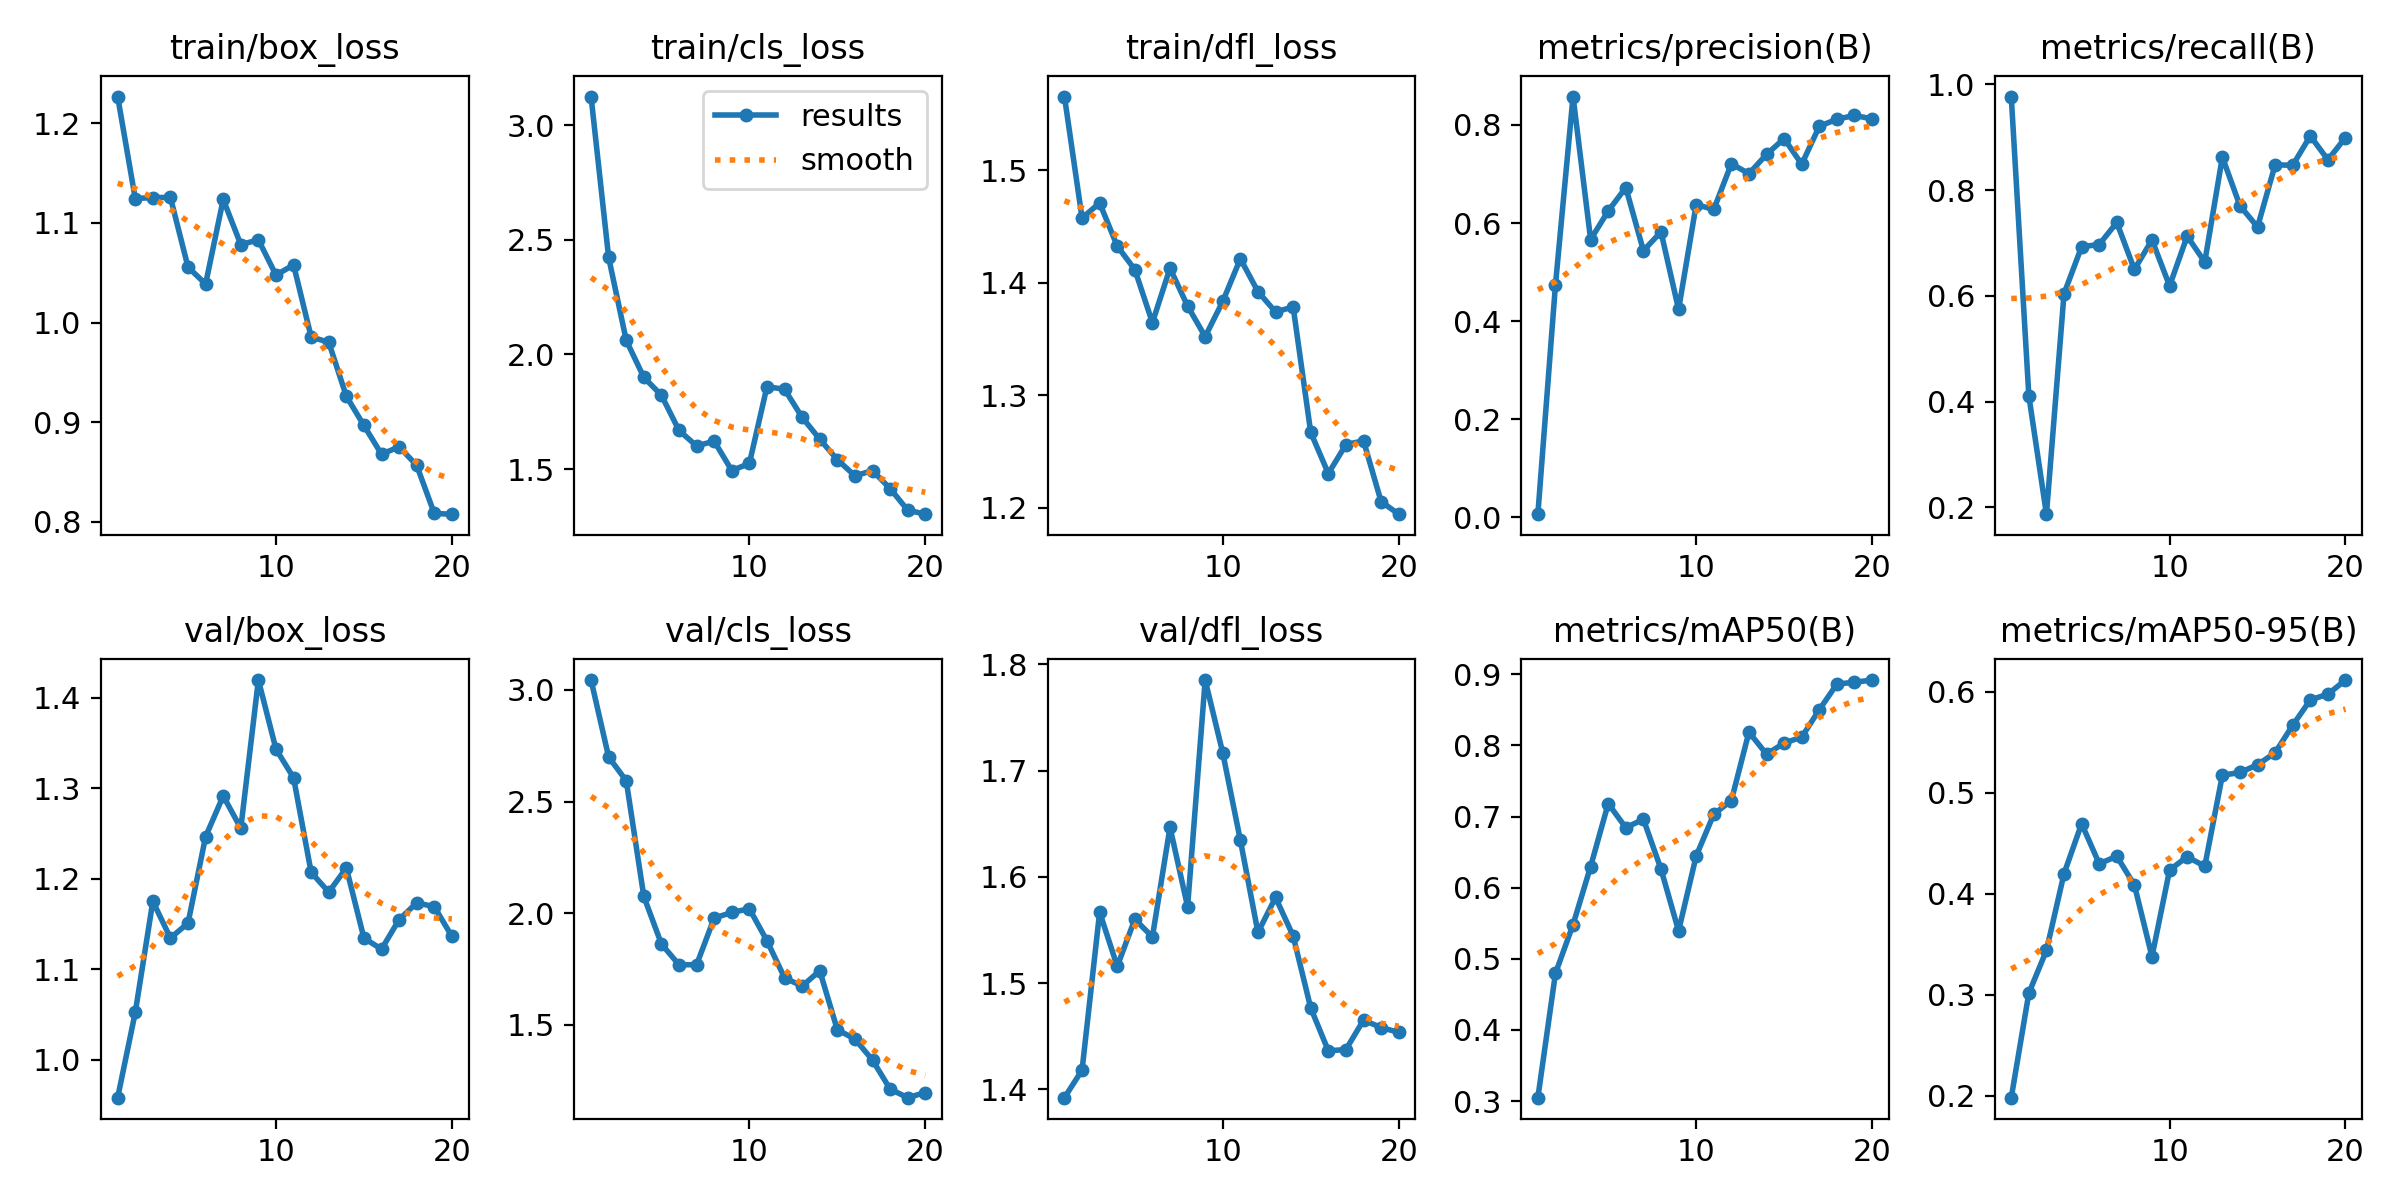

In [182]:
Display(filename='runs/detect/train13/results.png', width=1080)

**<font size="4" color="lightgreen">Посмотрим как она отрабатывала на валидационном батче</font>**

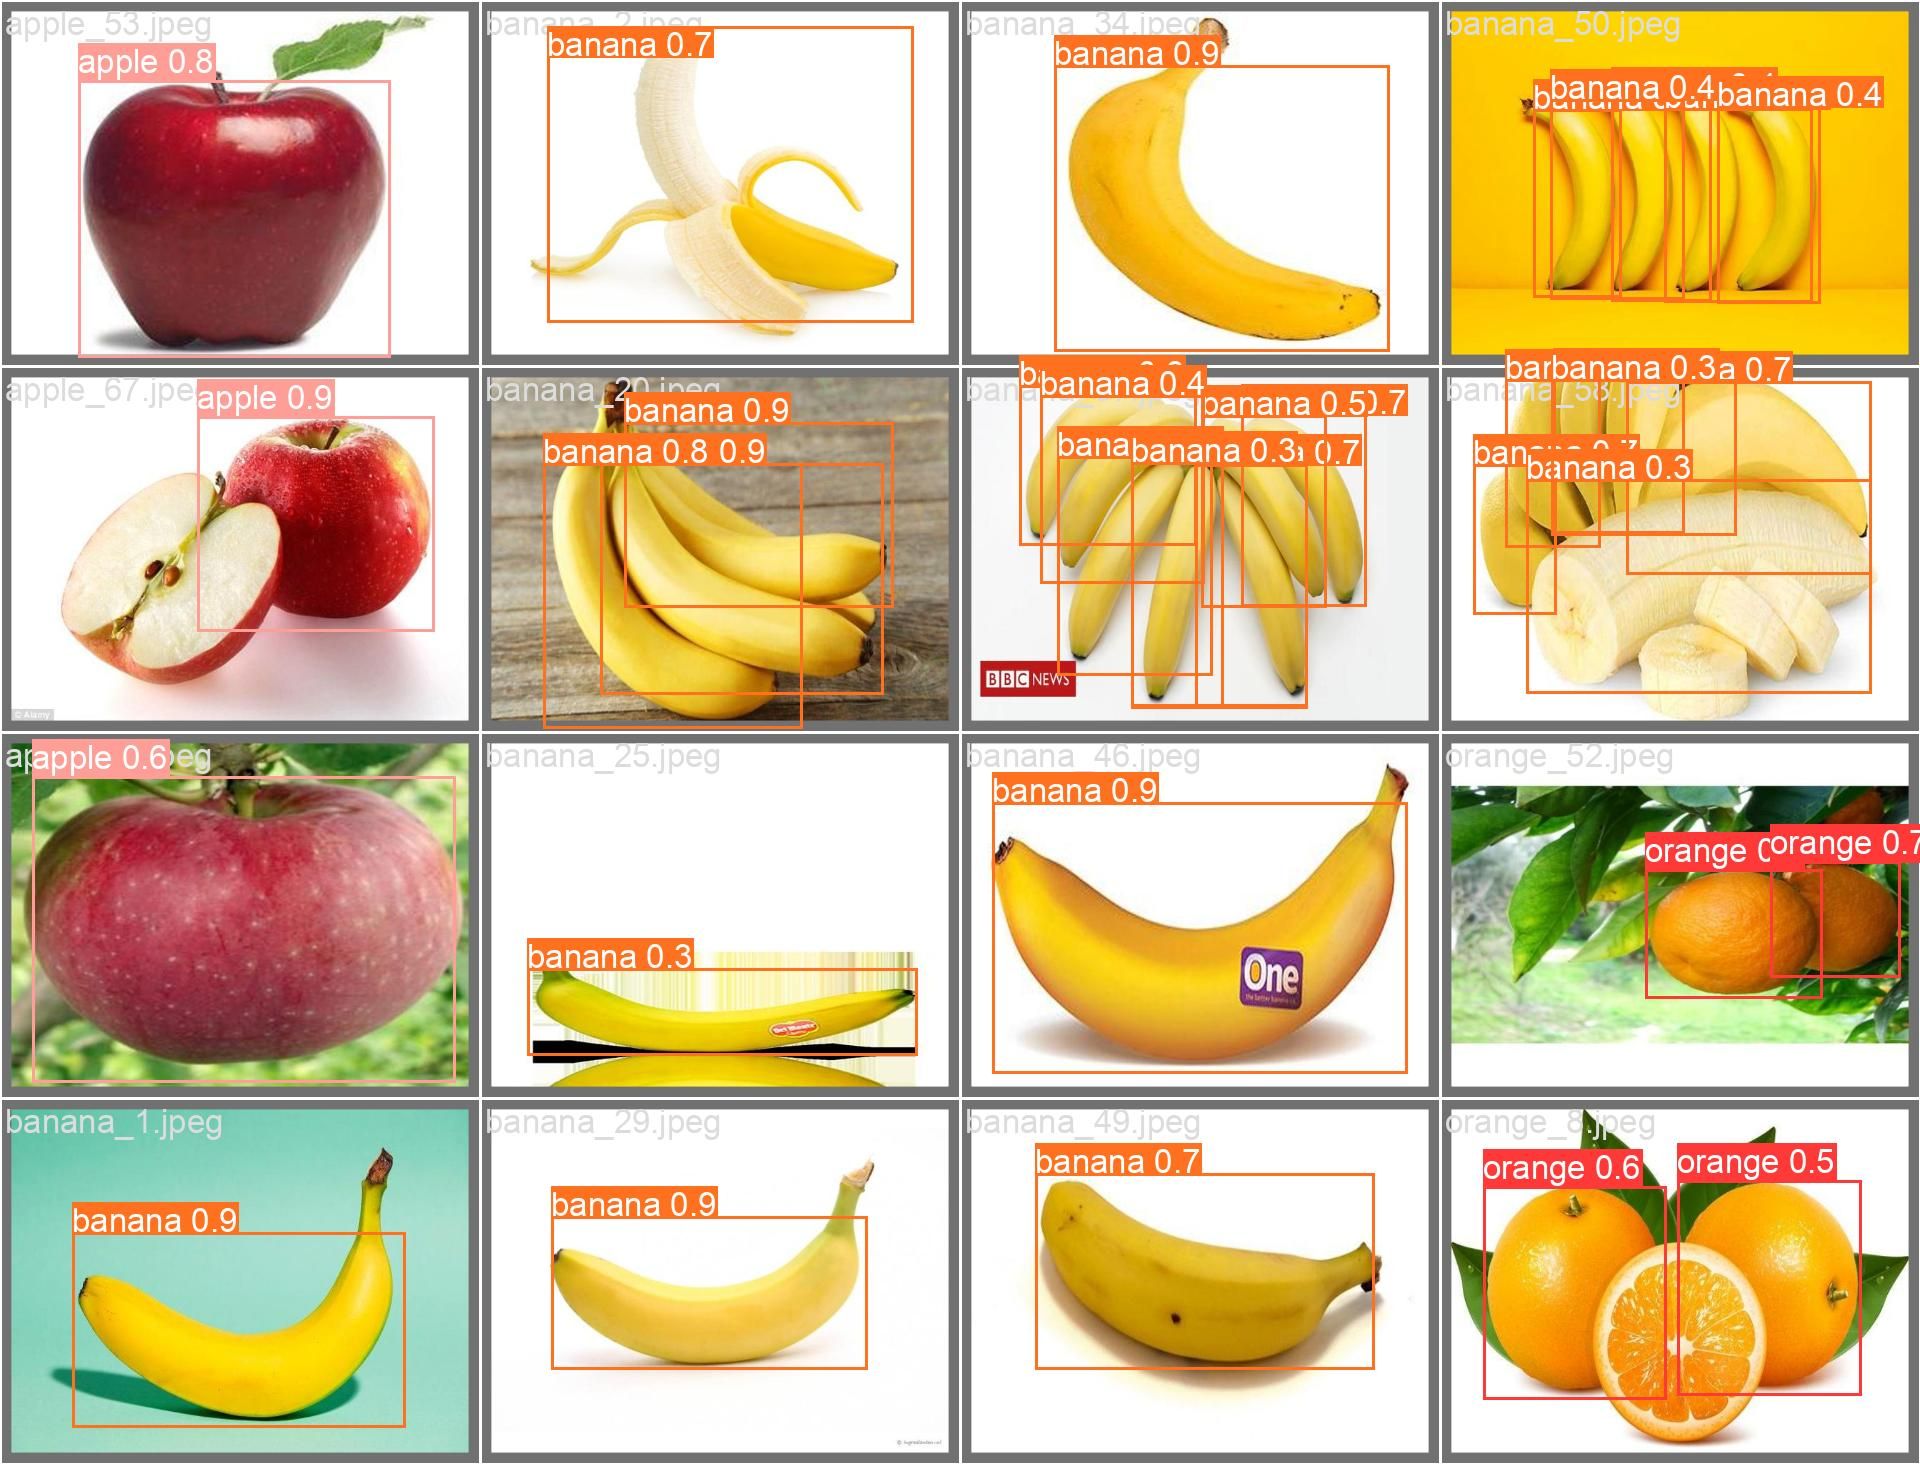

In [186]:
Display(filename='runs/detect/train13/val_batch1_pred.jpg', width=1080)

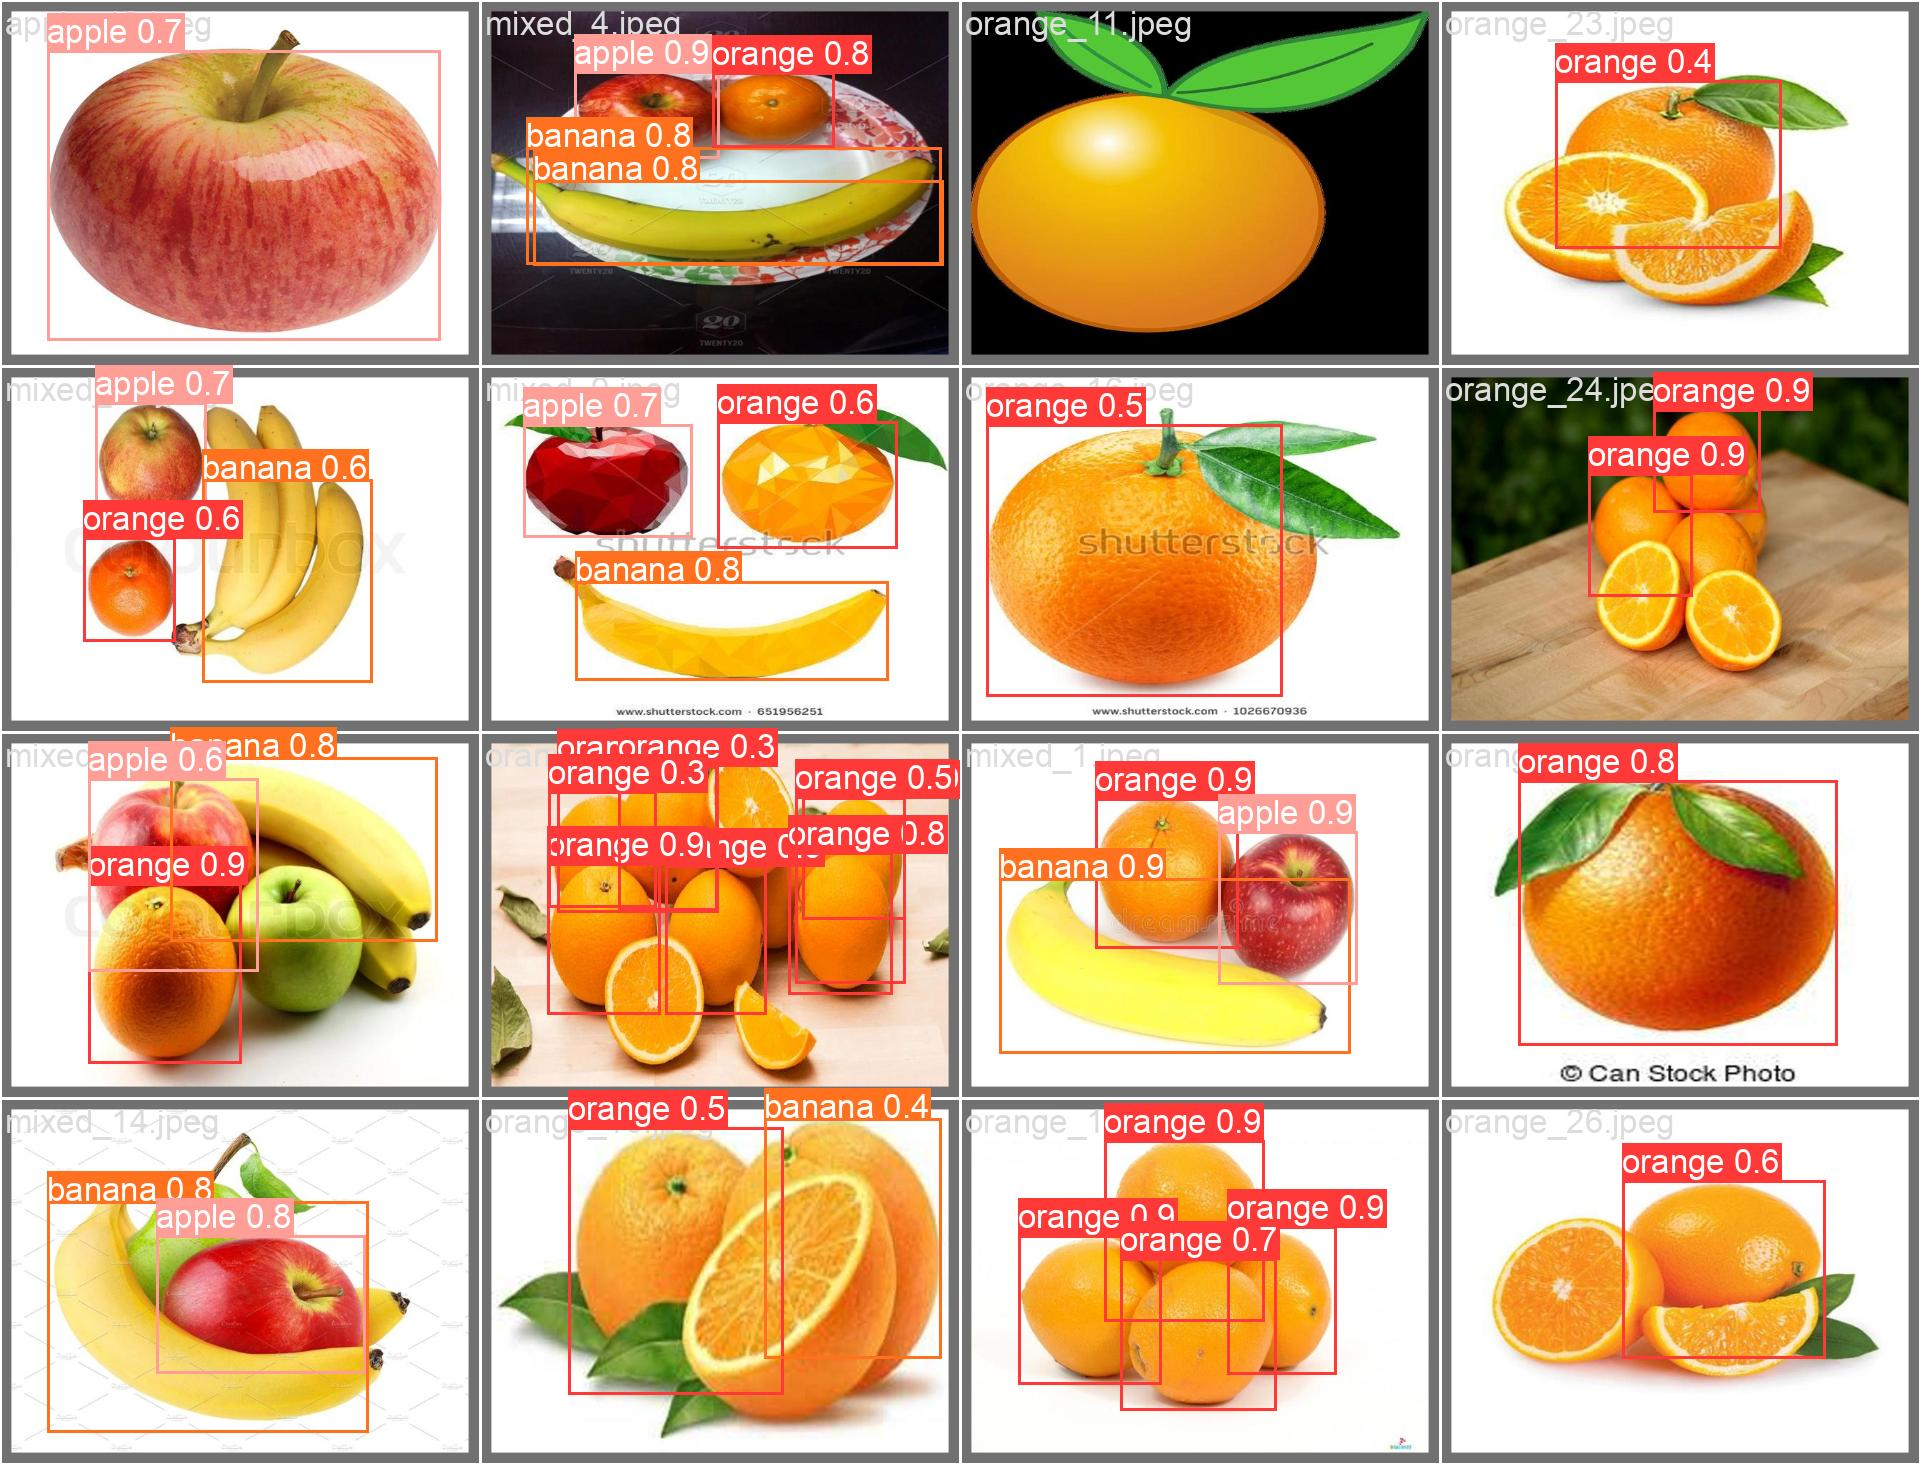

In [187]:
Display(filename='runs/detect/train13/val_batch0_pred.jpg', width=1080)

In [310]:
!ls

data  runs  yolov8n.pt


**<font size="4" color="lightgreen">Ну и протестируем модель на все тех же тестовых данных</font>**

In [292]:
results = model("/content/drive/MyDrive/detection/test", save_dir="/content/123", save=True, save_crop=True)


image 1/60 /content/drive/MyDrive/detection/test/apple_77.jpg: 512x640 4 apples, 60.7ms
image 2/60 /content/drive/MyDrive/detection/test/apple_78.jpg: 640x640 1 apple, 71.4ms
image 3/60 /content/drive/MyDrive/detection/test/apple_79.jpg: 640x640 1 apple, 39.0ms
image 4/60 /content/drive/MyDrive/detection/test/apple_80.jpg: 544x640 1 apple, 42.0ms
image 5/60 /content/drive/MyDrive/detection/test/apple_81.jpg: 640x576 1 apple, 53.6ms
image 6/60 /content/drive/MyDrive/detection/test/apple_82.jpg: 640x576 1 apple, 12.6ms
image 7/60 /content/drive/MyDrive/detection/test/apple_83.jpg: 608x640 1 apple, 11.9ms
image 8/60 /content/drive/MyDrive/detection/test/apple_84.jpg: 448x640 3 apples, 14.2ms
image 9/60 /content/drive/MyDrive/detection/test/apple_85.jpg: 512x640 1 apple, 12.9ms
image 10/60 /content/drive/MyDrive/detection/test/apple_86.jpg: 448x640 3 apples, 12.8ms
image 11/60 /content/drive/MyDrive/detection/test/apple_87.jpg: 640x640 1 apple, 12.1ms
image 12/60 /content/drive/MyDrive/de

In [302]:
!ls runs/detect/train132

apple_77.jpg  apple_88.jpg   banana_80.jpg  banana_91.jpg  orange_78.jpg  orange_90.jpg
apple_78.jpg  apple_89.jpg   banana_81.jpg  banana_92.jpg  orange_79.jpg  orange_91.jpg
apple_79.jpg  apple_90.jpg   banana_82.jpg  banana_93.jpg  orange_80.jpg  orange_92.jpg
apple_80.jpg  apple_91.jpg   banana_83.jpg  banana_94.jpg  orange_81.jpg  orange_93.jpg
apple_81.jpg  apple_92.jpg   banana_84.jpg  crops	   orange_82.jpg  orange_94.jpg
apple_82.jpg  apple_93.jpg   banana_85.jpg  mixed_21.jpg   orange_83.jpg  orange_95.jpg
apple_83.jpg  apple_94.jpg   banana_86.jpg  mixed_22.jpg   orange_84.jpg
apple_84.jpg  apple_95.jpg   banana_87.jpg  mixed_23.jpg   orange_85.jpg
apple_85.jpg  banana_77.jpg  banana_88.jpg  mixed_24.jpg   orange_86.jpg
apple_86.jpg  banana_78.jpg  banana_89.jpg  mixed_25.jpg   orange_87.jpg
apple_87.jpg  banana_79.jpg  banana_90.jpg  orange_77.jpg  orange_89.jpg


In [305]:
import matplotlib.image as mpimg

image_paths = [
    "runs/detect/train132/apple_77.jpg",
    "runs/detect/train132/orange_89.jpg",
    "runs/detect/train132/banana_92.jpg",
    "runs/detect/train132/mixed_25.jpg",
    "runs/detect/train132/mixed_23.jpg"
]

def show_images(image_paths):
    fig = plt.figure(figsize=(25, 6))
    for i, image_path in enumerate(image_paths, 1):
        ax = fig.add_subplot(1, 5, i)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis("off")
    plt.show()

show_images(image_paths)

**<font size="4" color="lightgreen">Я не понимаю почему тут ничего не вывелось, но допустим в скрипте ошибка, хотя выше все работало отлично</font>**

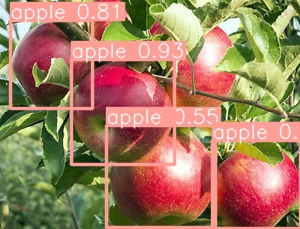

In [303]:
Display(filename='runs/detect/train132/apple_77.jpg', width=1080)

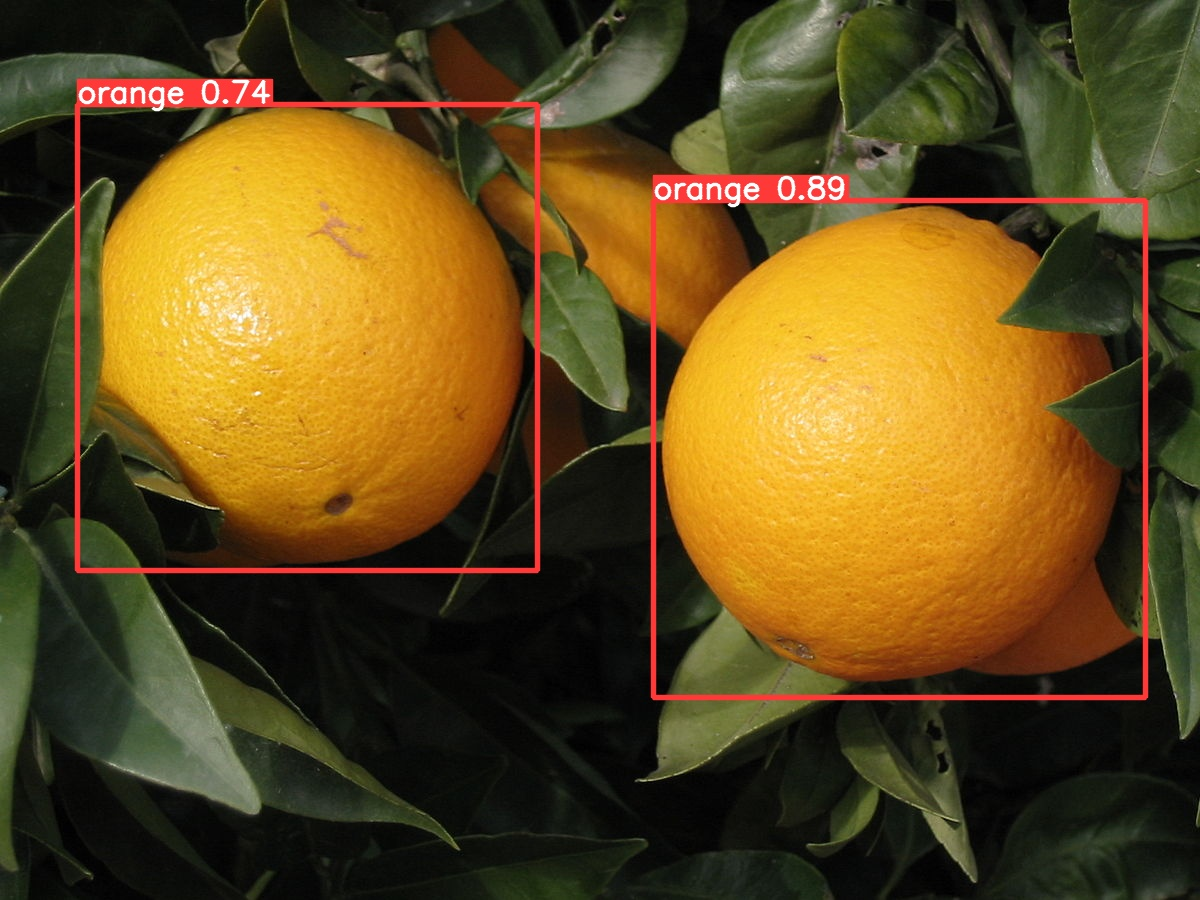

In [306]:
Display(filename='runs/detect/train132/orange_89.jpg', width=1080)

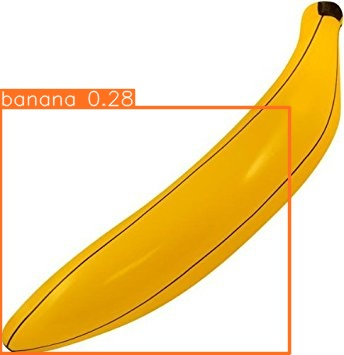

In [307]:
Display(filename='runs/detect/train132/banana_92.jpg', width=1080)

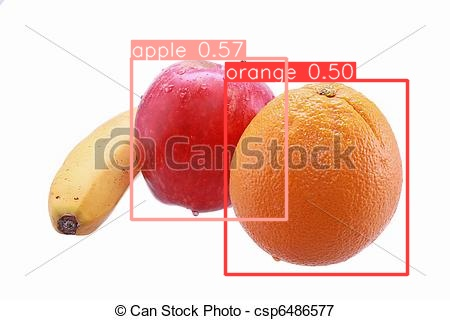

In [308]:
Display(filename='runs/detect/train132/mixed_25.jpg', width=1080)

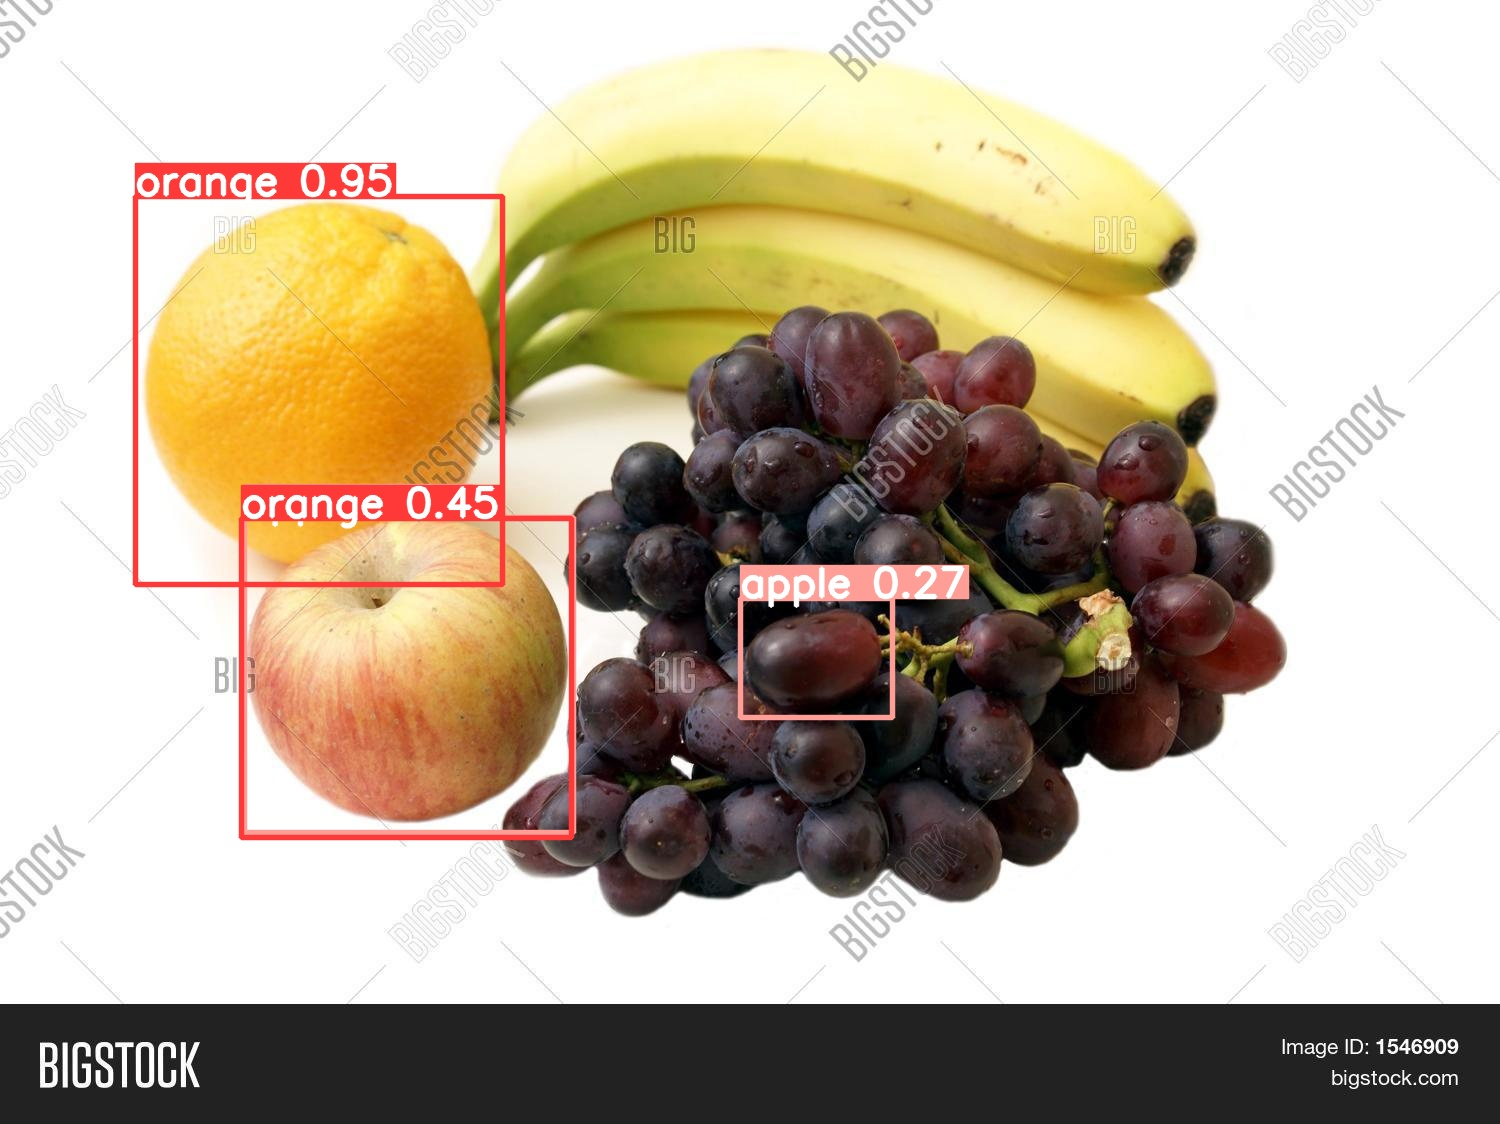

In [309]:
Display(filename='runs/detect/train132/mixed_23.jpg', width=1080)

## 5. Кейсы применения модели

Модель, которую я получил на выходе, может детектировать фрукты на изображениях, а значит, такую модель можно использовать для распознования и анализа фруктов на изображениях.

 - Например, модель можно использовать в розничной торговле, а конкретнее модель может автоматизировать переучет продуктов на полках и на складах, а именно нанимается человек или ставится камера видеонаблюдения, два раза в сутки (В начале и в конце смены) делает изображение и отправляет на обработку модели, далеее модель пересчитывает количество того или иниого продукта и информацию записывает, в качестве примера, в базу данных. Где будет храница статистика по всем проданным товарам, а также товару, который не удалось реализовать (Сделать это можно путем фотографирования продуктов перед их уничтожением, но тут нужна будет скорее всего другая модель, ибо я не знаю как поведут себя данные модели на протухших или сгнивших фруктах).

 - В качестве второго примера использования модели, которая может идентифицировать фрукты на изображениях, можно привести склад, где модель может применятся для сортировки прибывшего товара. Реализовать это можно с помощью конвеера, который будет сортировать фрукты или овощи исходя из ответов модели.

 - Также модель можно использовать в качестве создания мобильного приложения, которая будет помогать пользователю определять по фотографии сколько калорий он употребляет, где рачет будет происходить исходя из количество фруктов, которые нашла модель и перемножению их на среднюю каллорийность этого продукта. Приложение будет направленно на людей, которые сидят на диете, или просто считают каллорийность сьеденного за день.

P.S. Вообще я понимаю что все мои примеры натянуты за уши, и что для решение каждой из вышеприведенных проблем нужен более глубокий анализ и создание более гибких и глубоких нейросетей. Но я всего-лишь студент, который выполнял творческий проект в рамках двух недель. Поэтому если вы проверяющий и дошли до сЮДЫВА, то спасибо большое за выделенное время и удачи вам с проверкой следующий работ :)